<a href="https://colab.research.google.com/github/Warchiving/Warchiving-release/blob/main/src/recsys/Warchiving_Recsys_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re
from transformers import pipeline

# TODO
- ☑️ pricing_detail과 catering은 가격과 리뷰를 분리
- ☑️ 유사도가 아닌 호불호가 갈리는 리뷰 평가 -> 사용자 쿼리와의 유사도 측정
- ☑️ 페르소나 설정하여 딥러닝 추천시스템 구축(Re-ranking)
- ☑️ Ranking에서 상위 10개 + 랜덤 추천 10개
- ☑️ 상세페이지에 썸네일 화면도 영향을 줘야 하나?

# 실제 가공한 데이터셋으로 스코어링 모델 선정

In [ ]:
wedding_datasets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/59min/wedding_datasets_hall_지우기금지.csv')

In [ ]:
wedding_datasets.head(10)

,Unnamed: 0,name,hall_vibe,catering,parking_facility,transport_access,bridal_room,guest_flow,pricing_detail,service_etc,disadvantage,in_guarantee
0,0,신사 더컨벤션 단독홀,"꽉찬 육각형 홀과 어두운 홀에 높은 층고, 신식 건물로 외관이 고급스러움","16만원, 후기가 좋음",건물 내 주차 가능,신사역 도보 5분,신부대기실에서 웨딩홀로 바로 입장,하객 동선이 복잡할 가능성 있음,"1650만원, 모든 비용 일체 포함 전문 사회자 포함",당일 계약으로 혼주 식사가 무료(타사와 차이 없음),"높은 견적, 좁은 로비로 하객 동선 복잡함",200
1,1,반포 더컨벤션 단독홀,"어두운 홀, 단독홀, 신부 대기실 넓고 예쁨","11만원, 맛있기로 유명함",외부 주차장 이용 시 셔틀 타거나 도보 10분 필요,엘리베이터 내리면 직관적으로 홀과 신부 대기실이 보임,신부 대기실에서 입장이 아닌 로비 입장,연회장 이동 동선이 복잡함,"1100만원, 강남에서 고가에 속하지 않음",NaN,"연회장 이동 동선 불편, 약간 노후화된 외관",200
2,2,서울 웨스틴 파르나스 호텔 - 아틀라스 홀,"5성급 호텔, 층고가 낮은 홀, 전체적인 분위기와 플라워 디자인이 중요함","18만5천원, 대관료 220만원, 다양한 할인 혜택 포함",하객 무료주차 4시간,코엑스와 가까워 대중교통 접근성 좋음,신부대기실 플라워 디자인 자유롭게 결정 가능,"복잡하지 않음, ㄱ자 입장이 아닌 1자로 입장",할인으로 비용 부담 덜어짐,"다양한 서비스 제공, 샵에서 픽업 서비스",층고가 낮고 같은 층에 다른 웨딩홀이 있음,120
3,3,선릉 상록 아트홀,"어두운 홀 중에서 크고 넓음, 홀은 예쁨","식대 9.5만원, 뷔페식으로 top tier",NaN,"선릉역 도보 5분, 셔틀버스 수시 운행",NaN,로비가 좁아 하객 동선 복잡할 수 있음,"토요일 950만원, 일요일 850만원, 정찰제 느낌 강함",음향이 굉장히 좋음,"공무원 할인 외에 할인이 없음, 신부가 덜 주목받는 버진로드",250 (토요일 기준)
4,4,서울 강남 셀럽 엔 어셈,"무난한 분위기, 밝은 홀과 어두운 홀 모두 사용 가능, 생화 장식이 예쁨","97,000원, 음식 맛있음",NaN,NaN,NaN,"로비가 넓어 하객 붐비지 않음, 층고는 낮아 답답함","10월 10일: 30,765,000원, 10월 11일: 29,765,000원","친절한 안내, 음식 극찬","측면에서 입장해야 하는 점, 생화 향기가 강해 머리가 아팠음",250
5,5,강서 더퍼스트클래스파티,화이트 대리석 인테리어로 깔끔하고 통창이 있어 채광이 좋음,"성인 61,000원, 웨딩패키지 170만원, 음식이 깔끔하고 맛있어 보임","넓은 지하주차장, 주차장에서 식장까지 편하게 이동 가능",일산과 가까워 접근성이 좋음,NaN,홀 앞에 뷔페가 있어 하객들이 편리하게 이용 가능,NaN,"친절하고 자세한 상담, 계약 절차가 간편함","음료, 주류, 몇 가지 음식이 복도로 가야 하여 하객들에게 미리 안내 필요",60
6,6,천안 비렌티,"밝은 홀과 높은 층고, 넓은 공간","정가 식대 69,000원, 할인가 53,000~57,000원",1700대 수용 가능한 넓은 주차장,"천안터미널과 두정역에서 셔틀버스 운행, 자차 이용 시 천안 IC와 근접",신부대기실이 가장 큰 홀,하객 동선이 자유롭고 편리함,"대관료 5,900,000원, 합리적인 가격으로 느껴짐","상담 직원이 친절하고 상세하게 설명해줌, 상담 당일 할인 및 현장 할인 혜택 제공",대중교통 접근성이 좋지 않음,150
7,7,삼성 노블발렌티,"클래식한 채플홀, 고급스러움, 적당한 밝기, 층고 높음","10만원, 비수기 가격에 낮은 견적","내부와 외부 주차 가능, 직원들이 잘 관리","봉은사역 도보 6-7분, 지방 하객 편리",NaN,"여유로운 식 간격, 복잡하지 않음","대관료 1300만원, 비수기 가격으로 낮아짐","친절하고 전문적인 상담, 웨딩홀 상담 중 최고","코스요리로 인한 걱정, 하지만 맛있다는 후기가 많음",250
8,8,영등포 더베르G (더베르지),"넓고 깨끗한 단독홀, 생화 가득한 웨딩홀 분위기","11만원, 대관료 600만원, 플라워 디렉팅 1000만원","넓은 주차장, 주차 문제 없음","영등포 구청(2, 5호선) 및 영등포 시장(5호선) 도보 가능, 셔틀버스 운영",신부 대기실과 통로가 넓고 깨끗함,"하객 동선 간결, 단독홀로 겹치지 않음","대관료 600만원, 식대 11만원, 합리적 가격","직원 친절, 전문성 높음, 홀 투어 시 충분한 시간 제공",여름철 꽃 관리 및 에어컨 온도 제한 우려,200
9,9,dmc타워웨딩 펠리체홀,"차분하고 안정적인 분위기, 신뢰감 있는 상담","정가식대 88,000원, 대관료 1,700만원",NaN,대중교통 접근성이 좋음,NaN,NaN,"가격대가 예상보다 높음, 그러나 항목별 설명이 명확함","상담이 편하고 신뢰감이 높음, 운영 방식에 대한 설명이 좋음","가격대가 높고, 예식 당일 분주할 가능성",200


In [ ]:
tag_df = wedding_datasets.copy()

## 하드 필터링 col 분석 및 전처리
- 보증인원: 수치형 vs 범주형
- 웨딩홀 분위기: 주관적 리뷰
- 위치: 범주형
- 가격: 수치형 vs 범주형

*가격과 보증인원이 수치형과 범주형인 이유는 웨딩홀 도메인 상, 고객마다 할인가가 다르고 비공개 정보(ex. '대략 1500만원대 였습니다')가 많기 때문에 범주형으로 고려중임

### 보증인원 전처리

In [ ]:
import re

def string_to_int(row):
    idx = row.name
    text = str(row['in_guarantee']).strip()

    # 1. 데이터가 None이거나 비어있으면 그대로 유지
    if not text or text.lower() == 'None':
        return 'None'

    # 2. 숫자만 추출
    clean_text = re.sub(r'[^0-9]', '', text)

    # 3. 숫자 외의 글자가 섞여 있었는지 확인 (출력용)
    if clean_text != text:
        # 숫자가 아예 없는 문장이었는지 체크
        if not clean_text:
            print(f"❓ [Index {idx}] 숫자 없음 (None 유지): '{text}'")
            return 'None'
        else:
            print(f"⚠️ [Index {idx}] 글자 포함됨: '{text}' -> {clean_text}")

    # 4. 숫자만 남은 문자열 반환 (나중에 계산이 필요하면 int()로 감싸세요)
    return int(clean_text)

In [ ]:
tag_df['in_guarantee'][13] = 250
tag_df['in_guarantee'][26] = 200
tag_df['in_guarantee'][77] = 60
tag_df['in_guarantee'][154] = 100
tag_df['in_guarantee'][234] = 200
tag_df['in_guarantee'][249] = 200
tag_df['in_guarantee'][388] = 100


/tmp/ipython-input-572220833.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tag_df['in_guarantee'][13] = 250
/tmp/ipython-input-572220833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



In [ ]:
list = [13, 26, 77, 154, 234, 249, 388]

for idx in list:
  print("보증인원: ", tag_df['in_guarantee'][idx])

보증인원:  250
보증인원:  200
보증인원:  60
보증인원:  100
보증인원:  200
보증인원:  200
보증인원:  100


### 웨딩홀 분위기 전처리

In [ ]:
# 1. hall_vibe 자주 나오는 단어 찾기 (범주형 설계를 위한 분석)
# 모든 hall_vibe 텍스트를 하나로 합친 뒤 단어별로 쪼개서 빈도수를 셉니다.

vibe_text = " ".join(tag_df['hall_vibe'].astype(str))
# 의미 없는 단어(은/는/이/가 등)를 제외하고 싶다면 간단하게 2글자 이상만 추출
words = [word for word in re.findall(r'[가-힣]{2,}', vibe_text)]
vibe_counts = Counter(words).most_common(30)

print("\n📊 [hall_vibe] 자주 등장하는 단어 TOP 30 (이걸 보고 범주를 정하세요)")
for word, count in vibe_counts:
    print(f"{word}: {count}회")



📊 [hall_vibe] 자주 등장하는 단어 TOP 30 (이걸 보고 범주를 정하세요)
분위기: 139회
밝은: 62회
어두운: 60회
느낌: 54회
고급스러운: 48회
높은: 43회
밝고: 39회
층고가: 36회
층고: 34회
단독홀: 29회
넓은: 28회
깔끔하고: 25회
높고: 24회
있는: 22회
깔끔한: 22회
예쁜: 20회
넓고: 19회
공간: 17회
화려한: 16회
웅장한: 16회
생화: 15회
느낌의: 15회
로비: 14회
버진로드: 14회
가능: 13회
화사한: 13회
트인: 13회
홀에: 11회
예쁨: 11회
야외: 11회


In [ ]:
# 개별 문서별 hall_vibe
# 단어당 '언급된 리뷰 수' 계산 (중복 제거)
unique_vibe_counts = Counter()

stopwords = ['있는', '느낌', '예쁜', '로비', '느낌의', '분위기']

for text in tag_df['hall_vibe'].dropna():
    # 한 리뷰 내에서 중복되는 단어는 1번만 카운트 (set 사용)
    words = set(re.findall(r'[가-힣]{2,}', str(text)))
    # 불용어 제외 로직 추가 가능
    filtered_words = [w for w in words if w not in stopwords]
    unique_vibe_counts.update(filtered_words)

print("📊 [hall_vibe] 단어별 언급 리뷰 수 (TOP 20)")
for word, count in unique_vibe_counts.most_common(20):
    print(f"{word}: {count}개 리뷰에서 언급됨")

📊 [hall_vibe] 단어별 언급 리뷰 수 (TOP 20)
밝은: 62개 리뷰에서 언급됨
어두운: 59개 리뷰에서 언급됨
고급스러운: 48개 리뷰에서 언급됨
높은: 43개 리뷰에서 언급됨
밝고: 39개 리뷰에서 언급됨
층고가: 36개 리뷰에서 언급됨
층고: 34개 리뷰에서 언급됨
단독홀: 29개 리뷰에서 언급됨
넓은: 27개 리뷰에서 언급됨
깔끔하고: 25개 리뷰에서 언급됨
높고: 24개 리뷰에서 언급됨
깔끔한: 22개 리뷰에서 언급됨
넓고: 19개 리뷰에서 언급됨
공간: 17개 리뷰에서 언급됨
화려한: 16개 리뷰에서 언급됨
웅장한: 16개 리뷰에서 언급됨
생화: 15개 리뷰에서 언급됨
버진로드: 14개 리뷰에서 언급됨
가능: 13개 리뷰에서 언급됨
화사한: 13개 리뷰에서 언급됨


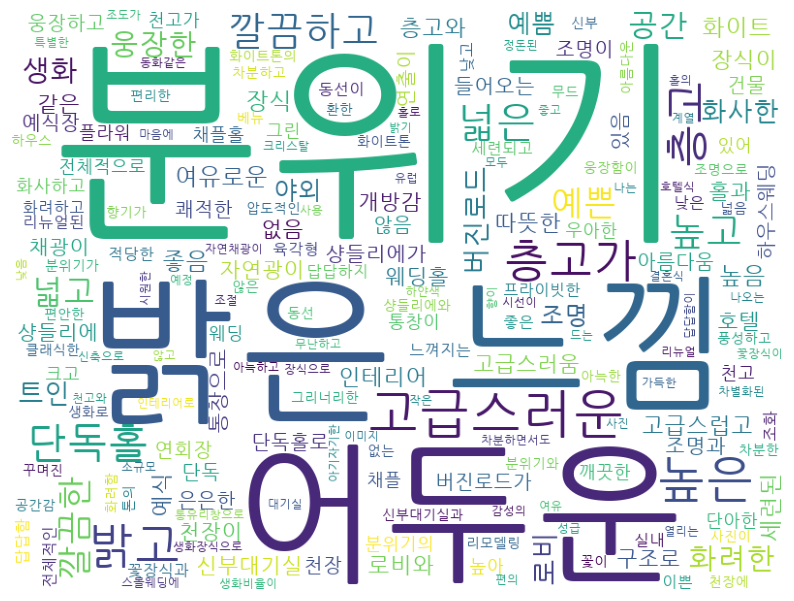

In [ ]:
from wordcloud import WordCloud

# 한글 폰트 설정 (아까 설정한 font_path 사용)
wc = WordCloud(font_path=selected_font, background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(unique_vibe_counts)

plt.figure(figsize=(10, 8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### 위치 전처리

In [ ]:
import pandas as pd
import re
from collections import Counter

# [1] 위치(Location) 추출을 위한 사전 정의 (주요 지역 키워드)
# 데이터 분석 결과에 따라 이 리스트를 계속 업데이트하세요.
location_map = {
    '강남/서초': ['강남', '서초', '반포', '신사', '양재', '선릉'],
    '영등포/구로': ['영등포', '문래', '신도림', '여의도'],
    '송파/강동': ['잠실', '송파', '문정', '강동'],
    '마포/강서': ['마포', '공덕', '강서', '마곡', 'DMC', '상암'],
    '중구/종로': ['종로', '중구', '을지로', '광화문'],
    '경기/인천': ['인천', '부천', '수원', '용인', '기흥', '판교', '성남', '분당', '안성', '평택', '천안', '동탄']
}

def extract_location(name):
    name = str(name)
    for loc, keywords in location_map.items():
        if any(key in name for key in keywords):
            return loc
    return '기타/서울'

# [2] Hall Vibe 범주형 수치화 (0 또는 1)
def categorize_vibe(text):
    text = str(text)
    return pd.Series({
        'is_bright': 1 if any(word in text for word in ['밝은', '밝고', '화사한', '화이트']) else 0,
        'is_dark': 1 if any(word in text for word in ['어두운', '블랙', '호텔식']) else 0,
        'is_high_ceiling': 1 if any(word in text for word in ['층고', '높은', '높고', '웅장', '트인']) else 0,
        'is_private': 1 if '단독' in text else 0,
        'is_outdoor': 1 if any(word in text for word in ['야외', '가든', '야외예식']) else 0,
        'is_grand': 1 if any(word in text for word in ['웅장', '화려한', '넓은', '공간']) else 0
    })

# 데이터 적용
# 1. 위치 컬럼 생성
tag_df['location'] = tag_df['name'].apply(extract_location)

# 2. 분위기 범주형 컬럼 생성 (기존 df에 합치기)
vibe_features = tag_df['hall_vibe'].apply(categorize_vibe)
final_analysis_df = pd.concat([tag_df, vibe_features], axis=1)

print("✅ 위치 및 범주형 데이터 생성 완료")
print(final_analysis_df[['name', 'location', 'is_bright', 'is_dark', 'is_high_ceiling']].head())

✅ 위치 및 범주형 데이터 생성 완료
                      name location  is_bright  is_dark  is_high_ceiling
0              신사 더컨벤션 단독홀    강남/서초          0        1                1
1              반포 더컨벤션 단독홀    강남/서초          0        1                0
2  서울 웨스틴 파르나스 호텔 - 아틀라스 홀    기타/서울          0        0                1
3                선릉 상록 아트홀    강남/서초          0        1                0
4            서울 강남 셀럽 엔 어셈    강남/서초          1        1                0


In [ ]:
tag_df['location'].unique()

array(['강남/서초', '기타/서울', '마포/강서', '경기/인천', '영등포/구로', '송파/강동', '중구/종로'],
      dtype=object)

In [ ]:
tag_df['location'].value_counts()

,count
location,
기타/서울,218
경기/인천,81
영등포/구로,42
강남/서초,37
마포/강서,22
송파/강동,10
중구/종로,2


In [ ]:
tag_df.head()

,Unnamed: 0,name,hall_vibe,catering,parking_facility,transport_access,bridal_room,guest_flow,pricing_detail,service_etc,disadvantage,in_guarantee,location
0,0,신사 더컨벤션 단독홀,"꽉찬 육각형 홀과 어두운 홀에 높은 층고, 신식 건물로 외관이 고급스러움","16만원, 후기가 좋음",건물 내 주차 가능,신사역 도보 5분,신부대기실에서 웨딩홀로 바로 입장,하객 동선이 복잡할 가능성 있음,"1650만원, 모든 비용 일체 포함 전문 사회자 포함",당일 계약으로 혼주 식사가 무료(타사와 차이 없음),"높은 견적, 좁은 로비로 하객 동선 복잡함",200,강남/서초
1,1,반포 더컨벤션 단독홀,"어두운 홀, 단독홀, 신부 대기실 넓고 예쁨","11만원, 맛있기로 유명함",외부 주차장 이용 시 셔틀 타거나 도보 10분 필요,엘리베이터 내리면 직관적으로 홀과 신부 대기실이 보임,신부 대기실에서 입장이 아닌 로비 입장,연회장 이동 동선이 복잡함,"1100만원, 강남에서 고가에 속하지 않음",NaN,"연회장 이동 동선 불편, 약간 노후화된 외관",200,강남/서초
2,2,서울 웨스틴 파르나스 호텔 - 아틀라스 홀,"5성급 호텔, 층고가 낮은 홀, 전체적인 분위기와 플라워 디자인이 중요함","18만5천원, 대관료 220만원, 다양한 할인 혜택 포함",하객 무료주차 4시간,코엑스와 가까워 대중교통 접근성 좋음,신부대기실 플라워 디자인 자유롭게 결정 가능,"복잡하지 않음, ㄱ자 입장이 아닌 1자로 입장",할인으로 비용 부담 덜어짐,"다양한 서비스 제공, 샵에서 픽업 서비스",층고가 낮고 같은 층에 다른 웨딩홀이 있음,120,기타/서울
3,3,선릉 상록 아트홀,"어두운 홀 중에서 크고 넓음, 홀은 예쁨","식대 9.5만원, 뷔페식으로 top tier",NaN,"선릉역 도보 5분, 셔틀버스 수시 운행",NaN,로비가 좁아 하객 동선 복잡할 수 있음,"토요일 950만원, 일요일 850만원, 정찰제 느낌 강함",음향이 굉장히 좋음,"공무원 할인 외에 할인이 없음, 신부가 덜 주목받는 버진로드",250 (토요일 기준),강남/서초
4,4,서울 강남 셀럽 엔 어셈,"무난한 분위기, 밝은 홀과 어두운 홀 모두 사용 가능, 생화 장식이 예쁨","97,000원, 음식 맛있음",NaN,NaN,NaN,"로비가 넓어 하객 붐비지 않음, 층고는 낮아 답답함","10월 10일: 30,765,000원, 10월 11일: 29,765,000원","친절한 안내, 음식 극찬","측면에서 입장해야 하는 점, 생화 향기가 강해 머리가 아팠음",250,강남/서초


### 가격 전처리

#### 전처리(가격 제외) 데이터셋 저장

In [ ]:
tag_df.to_csv('processed_weddingHall.csv')

## 주관적인 리뷰 스코어링하기


2. 가중치 기반 최종 스코어링 수식 설계사용자가 뽑은 우선순위 3개에 가중치를 부여하는 로직입니다.$$Final\_Score = \sum_{i=1}^{n} (Score_i \times Weight_i)$$1순위 가중치: 1.52순위 가중치: 1.23순위 가중치: 1.0나머지: 0.5 (또는 0)

☑️ 후보 모델,특징,추천 사유:

1. KoBERT-Multiclass (3-class),"-1, 0, 1(또는 2)로 라벨링된 웨딩 데이터를 학습시킨 모델입니다.","님의 점수 체계(-1, 0, 2)에 가장 직관적으로 부합합니다."

2. KoBERT + Softmax Probability,"긍정/부정 확률값을 뽑아낸 뒤, 특정 임계값(Threshold) 사이를 0점으로 처리합니다.",중립(0점)의 범위를 님이 직접 미세하게 조정할 수 있습니다.

3. KcBERT (Comment BERT),네이버 뉴스 댓글 등 구어체로 학습된 BERT입니다.,블로그나 카페 리뷰 특유의 신조어와 이모티콘 처리에 더 강합니다.

4. KoBERT-Cross-Encoder,리뷰와 '기준 문장'을 비교하여 유사도를 점수화합니다.,"""식사가 맛있다""라는 기준과 얼마나 유사한지 수치화할 수 있습니다."

---

✅ 사용한 모델

1. Bert 기반 모델
- snunlp/KR-FinBert-SC
- jaehyeong/koelectra-base-v3-generalized-sentiment-analysis
- daekeun-ml/koelectra-small-v3-nsmc

2. NLP 기반 모델
- hgan/ko-sroberta-multitask
- sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [ ]:
!pip install transformers torch

In [ ]:
tag_df.head()

,Unnamed: 0,name,hall_vibe,catering,parking_facility,transport_access,bridal_room,guest_flow,pricing_detail,service_etc,disadvantage,in_guarantee,location
0,0,신사 더컨벤션 단독홀,"꽉찬 육각형 홀과 어두운 홀에 높은 층고, 신식 건물로 외관이 고급스러움","16만원, 후기가 좋음",건물 내 주차 가능,신사역 도보 5분,신부대기실에서 웨딩홀로 바로 입장,하객 동선이 복잡할 가능성 있음,"1650만원, 모든 비용 일체 포함 전문 사회자 포함",당일 계약으로 혼주 식사가 무료(타사와 차이 없음),"높은 견적, 좁은 로비로 하객 동선 복잡함",200,강남/서초
1,1,반포 더컨벤션 단독홀,"어두운 홀, 단독홀, 신부 대기실 넓고 예쁨","11만원, 맛있기로 유명함",외부 주차장 이용 시 셔틀 타거나 도보 10분 필요,엘리베이터 내리면 직관적으로 홀과 신부 대기실이 보임,신부 대기실에서 입장이 아닌 로비 입장,연회장 이동 동선이 복잡함,"1100만원, 강남에서 고가에 속하지 않음",NaN,"연회장 이동 동선 불편, 약간 노후화된 외관",200,강남/서초
2,2,서울 웨스틴 파르나스 호텔 - 아틀라스 홀,"5성급 호텔, 층고가 낮은 홀, 전체적인 분위기와 플라워 디자인이 중요함","18만5천원, 대관료 220만원, 다양한 할인 혜택 포함",하객 무료주차 4시간,코엑스와 가까워 대중교통 접근성 좋음,신부대기실 플라워 디자인 자유롭게 결정 가능,"복잡하지 않음, ㄱ자 입장이 아닌 1자로 입장",할인으로 비용 부담 덜어짐,"다양한 서비스 제공, 샵에서 픽업 서비스",층고가 낮고 같은 층에 다른 웨딩홀이 있음,120,기타/서울
3,3,선릉 상록 아트홀,"어두운 홀 중에서 크고 넓음, 홀은 예쁨","식대 9.5만원, 뷔페식으로 top tier",NaN,"선릉역 도보 5분, 셔틀버스 수시 운행",NaN,로비가 좁아 하객 동선 복잡할 수 있음,"토요일 950만원, 일요일 850만원, 정찰제 느낌 강함",음향이 굉장히 좋음,"공무원 할인 외에 할인이 없음, 신부가 덜 주목받는 버진로드",250 (토요일 기준),강남/서초
4,4,서울 강남 셀럽 엔 어셈,"무난한 분위기, 밝은 홀과 어두운 홀 모두 사용 가능, 생화 장식이 예쁨","97,000원, 음식 맛있음",NaN,NaN,NaN,"로비가 넓어 하객 붐비지 않음, 층고는 낮아 답답함","10월 10일: 30,765,000원, 10월 11일: 29,765,000원","친절한 안내, 음식 극찬","측면에서 입장해야 하는 점, 생화 향기가 강해 머리가 아팠음",250,강남/서초


In [ ]:
personal_column = ['catering','bridal_room', 'service_etc', 'disadvantage'] # 일단 pricing_detail은 제거함

In [ ]:
def get_score(text, pipe):
    if not text or str(text).lower() == 'none' or len(str(text)) < 2:
        return 0
    try:
        result = pipe(text)[0]
        label = str(result['label']).upper()
        # 긍정 신호 체크
        if any(key in label for key in ['Positive','positive', 1]):
            return 2
        # 부정 신호 체크
        elif any(key in label for key in ['Negative','negative', 0]):
            return -1
        return 0
    except:
        return 0


#### 분류 모델로 스코어링

In [ ]:
import torch
model_names = [
    "snunlp/KR-FinBert-SC",
    "Copycats/koelectra-base-v3-generalized-sentiment-analysis",
    "daekeun-ml/koelectra-small-v3-nsmc"
]
print("모델 로딩 중...")
classifiers = [pipeline("sentiment-analysis", model=m, device=0 if torch.cuda.is_available() else -1) for m in model_names]
print("모델 로딩완료")


print("🚀 항목별/모델별 스코어링 시작...")


for i, pipe in enumerate(classifiers):
    m_num = i + 1
    for col in personal_column:
        # 컬럼명 규칙: 항목_모델번호_score (예: catering_m1_score)
        new_col_name = f"{col}_m{m_num}_score"
        tag_df[new_col_name] = tag_df[col].apply(lambda x: get_score(x, pipe))
        print(f"✅ 생성 완료: {new_col_name}")

print("\n✨ 모든 스코어링 계산이 완료되었습니다.")

모델 로딩 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/406M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/406M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


모델 로딩완료
🚀 항목별/모델별 스코어링 시작...
✅ 생성 완료: catering_m1_score
✅ 생성 완료: bridal_room_m1_score
✅ 생성 완료: service_etc_m1_score
✅ 생성 완료: disadvantage_m1_score
✅ 생성 완료: catering_m2_score
✅ 생성 완료: bridal_room_m2_score
✅ 생성 완료: service_etc_m2_score
✅ 생성 완료: disadvantage_m2_score
✅ 생성 완료: catering_m3_score
✅ 생성 완료: bridal_room_m3_score
✅ 생성 완료: service_etc_m3_score
✅ 생성 완료: disadvantage_m3_score

✨ 모든 스코어링 계산이 완료되었습니다.


In [ ]:
# 결과를 담을 리스트
dist_list = []

# 모델은 3개, 항목은 personal_column 리스트 기준
for m_idx in range(1, 4):
    for col in personal_column:
        score_col = f"{col}_m{m_idx}_score"
        if score_col in tag_df.columns:
            counts = tag_df[score_col].value_counts()
            dist_list.append({
                'Model': f'Model {m_idx}',
                'Item': col,
                'Positive(2)': counts.get(2.0, 0),
                'Neutral(0)': counts.get(0.0, 0),
                'Negative(-1)': counts.get(-1.0, 0)
            })

# 데이터프레임 변환 후 피벗 테이블 생성
summary_df = pd.DataFrame(dist_list)
pivot_summary = summary_df.pivot(index='Item', columns='Model', values=['Positive(2)', 'Negative(-1)'])

print("📊 [모델별 vs 항목별 긍정/부정 판정 건수 비교]")
display(pivot_summary)

📊 [모델별 vs 항목별 긍정/부정 판정 건수 비교]


Positive(2)                 Negative(-1)                
Model            Model 1 Model 2 Model 3      Model 1 Model 2 Model 3
Item                                                                 
bridal_room            0       0       0            0       0       0
catering               0       0       0            0       0       0
disadvantage           0       0       0            0       0       0
service_etc            0       0       0            0       0       0

#### nlp모델로 스코어링

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

# 1. 의미 비교에 특화된 NLP 모델 로드
nlp_model_names = [
    "jhgan/ko-sroberta-multitask",   # 문장 임베딩 성능 우수
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" # 다국어 지원 가벼운 모델
]

print("📦 NLP 임베딩 모델 로딩 중...")
nlp_models = [SentenceTransformer(m, device='cuda' if torch.cuda.is_available() else 'cpu') for m in nlp_model_names]
print("✅ 로딩 완료")


📦 NLP 임베딩 모델 로딩 중...


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ 로딩 완료


In [ ]:
# 2. 각 항목별 '완벽한 긍정'의 기준이 되는 문장 정의 (이 문장과 비슷할수록 높은 점수)
reference_positives = {
    'catering': "음식이 정말 맛있고 고급스러우며, 가짓수가 다양하다. 음식의 퀄리티가 훌륭합니다. 가성비가 좋다.",
    'bridal_room': "신부대기실이 넓고 화사하며 인테리어가 예쁩니다. 사진찍기에 좋아요. 바로 홀입장 가능하여  동선이 편리하다. 예쁘다. ",
    'service_etc': "하객들 동선이 짧음. 직관적임. 붐비지않음. 직원들이 매우 친절하고 서비스가 전문적이며 전반적인 운영이 매끄럽습니다.",
    'disadvantage': "단점이 거의 없으며 모든 면에서 만족스러운 완벽한 홀입니다."
}

In [ ]:
def get_nlp_similarity_score(text, model, ref_text):
    if not text or str(text).lower() == 'none' or len(str(text)) < 5:
        return 0.0

    # 두 문장을 벡터로 변환
    embeddings = model.encode([text, ref_text], convert_to_tensor=True)

    # 코사인 유사도 계산 (0~1 사이 값)
    cosine_sim = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()

    # 기존 점수 체계(-1, 0, 2)와 맞추기 위한 스케일링 (예: 유사도 0.7 이상이면 2점 취급 등)
    if cosine_sim > 0.6: return 2
    elif cosine_sim < 0.3: return -1
    else: return 0

print("🚀 NLP 유사도 기반 항목별/모델별 스코어링 시작...")

# 1차 필터링된 candidate_df 또는 model_df 사용
for i, model in enumerate(nlp_models):
    m_num = i + 1
    for col in personal_column:
        new_col_name = f"{col}_m{m_num}_score"
        ref_text = reference_positives[col] # 해당 항목의 기준 문장 추출

        # 모델별 유사도 점수 계산
        tag_df[new_col_name] = tag_df[col].apply(lambda x: get_nlp_similarity_score(x, model, ref_text))
        print(f"✅ 생성 완료 (NLP Similarity): {new_col_name}")

print("\n✨ 모든 NLP 기반 스코어링이 완료되었습니다.")

🚀 NLP 유사도 기반 항목별/모델별 스코어링 시작...
✅ 생성 완료 (NLP Similarity): catering_m1_score
✅ 생성 완료 (NLP Similarity): bridal_room_m1_score
✅ 생성 완료 (NLP Similarity): service_etc_m1_score
✅ 생성 완료 (NLP Similarity): disadvantage_m1_score
✅ 생성 완료 (NLP Similarity): catering_m2_score
✅ 생성 완료 (NLP Similarity): bridal_room_m2_score
✅ 생성 완료 (NLP Similarity): service_etc_m2_score
✅ 생성 완료 (NLP Similarity): disadvantage_m2_score

✨ 모든 NLP 기반 스코어링이 완료되었습니다.


#### 모델별 Test sample 출력

In [ ]:
tag_df.head(1)

,Unnamed: 0,name,hall_vibe,catering,parking_facility,transport_access,bridal_room,guest_flow,pricing_detail,service_etc,...,in_guarantee,location,catering_m1_score,bridal_room_m1_score,service_etc_m1_score,disadvantage_m1_score,catering_m2_score,bridal_room_m2_score,service_etc_m2_score,disadvantage_m2_score
0,0,신사 더컨벤션 단독홀,"꽉찬 육각형 홀과 어두운 홀에 높은 층고, 신식 건물로 외관이 고급스러움","16만원, 후기가 좋음",건물 내 주차 가능,신사역 도보 5분,신부대기실에서 웨딩홀로 바로 입장,하객 동선이 복잡할 가능성 있음,"1650만원, 모든 비용 일체 포함 전문 사회자 포함",당일 계약으로 혼주 식사가 무료(타사와 차이 없음),...,200,강남/서초,0.0,2.0,0.0,-1.0,-1.0,0.0,-1.0,0.0


In [ ]:
tag_df['disadvantage'][0]

'높은 견적, 좁은 로비로 하객 동선 복잡함'

In [ ]:
check_list = ['catering_m1_score','bridal_room_m1_score','service_etc_m1_score', 'disadvantage_m1_score']

for col in check_list:
  print(col, tag_df[col].value_counts())

catering_m1_score catering_m1_score
 0.0    238
 2.0     95
-1.0     79
Name: count, dtype: int64
bridal_room_m1_score bridal_room_m1_score
 0.0    285
 2.0    123
-1.0      4
Name: count, dtype: int64
service_etc_m1_score service_etc_m1_score
 0.0    317
-1.0     91
 2.0      4
Name: count, dtype: int64
disadvantage_m1_score disadvantage_m1_score
-1.0    270
 0.0    142
Name: count, dtype: int64


In [ ]:
# tag_df = tag_df.drop(['catering_m3_score', 'bridal_room_m3_score','service_etc_m3_score','disadvantage_m3_score'],axis=1)

In [ ]:
# 결과를 담을 리스트 생성
dist_list = []

for m_idx in [1, 2]:
    for col in personal_column:
        score_col = f"{col}_m{m_idx}_score"
        counts = tag_df[score_col].value_counts()
        dist_list.append({
            'Model': f'Model {m_idx}',
            'Item': col,
            'Neg(-1)': counts.get(-1.0, 0),
            'Neu(0)': counts.get(0.0, 0),
            'Pos(2)': counts.get(2.0, 0)
        })

# 데이터프레임 변환 후 피벗 테이블로 출력
dist_df = pd.DataFrame(dist_list)
dist_pivot = dist_df.pivot(index='Item', columns='Model', values=['Neg(-1)', 'Neu(0)', 'Pos(2)'])

print("📊 [모델별 vs 항목별 점수 분포 요약표]")
display(dist_pivot)

📊 [모델별 vs 항목별 점수 분포 요약표]


Neg(-1)          Neu(0)          Pos(2)        
Model        Model 1 Model 2 Model 1 Model 2 Model 1 Model 2
Item                                                        
bridal_room        4      57     285     316     123      39
catering          79     223     238     170      95      19
disadvantage     270     252     142     160       0       0
service_etc       91     164     317     240       4       8

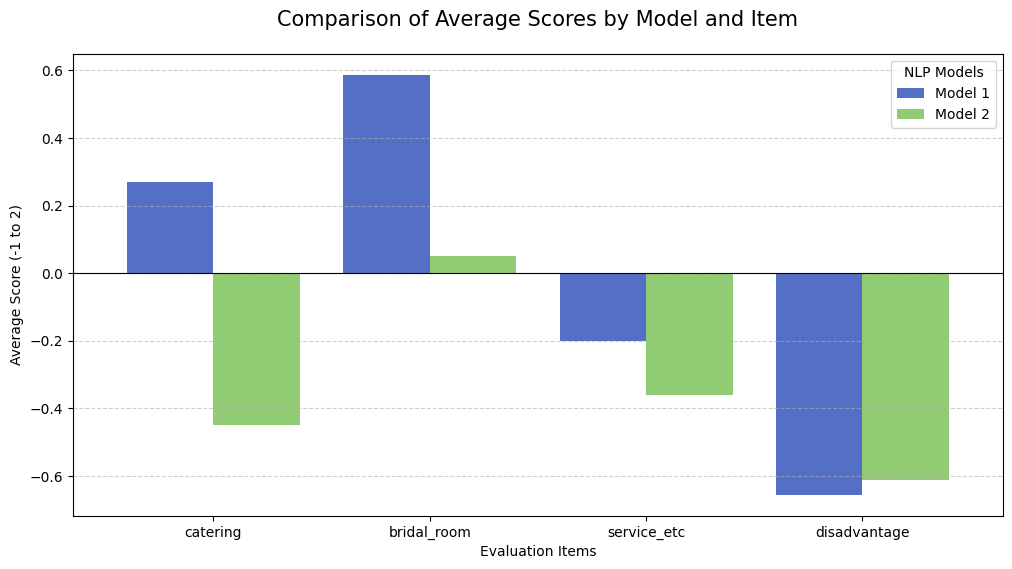

In [ ]:
import matplotlib.pyplot as plt

# 시각화용 데이터 준비 (항목별/모델별 평균 점수)
mean_scores = []
for col in personal_column:
    item_means = {'Item': col}
    for m_idx in [1, 2]:
        item_means[f'Model {m_idx}'] = tag_df[f'{col}_m{m_idx}_score'].mean()
    mean_scores.append(item_means)

mean_df = pd.DataFrame(mean_scores).set_index('Item')

# 막대그래프 출력
ax = mean_df.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#5470c6', '#91cc75', '#fac858'])
plt.title("Comparison of Average Scores by Model and Item", fontsize=15, pad=20)
plt.ylabel("Average Score (-1 to 2)")
plt.xlabel("Evaluation Items")
plt.xticks(rotation=0)
plt.legend(title="NLP Models", loc='upper right')
plt.axhline(0, color='black', linewidth=0.8) # 0점 라인 표시
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

#### 저장

In [ ]:
tag_df.to_csv('nlp_scoring_hall_datasets.csv')

## 1차 하드 필터링

## Ranking화

In [ ]:
import pandas as pd
import random

# [설정] 사용자 우선순위 및 가중치 (기존 로직 유지)
user_priority = ['catering', 'service_etc', 'bridal_room']
all_personal_cols = ['catering', 'bridal_room', 'service_etc', 'disadvantage']

weights = {
    user_priority[0]: 1.5,
    user_priority[1]: 1.2,
    user_priority[2]: 1.0,
    'disadvantage': 1.0
}
for col in all_personal_cols:
    if col not in weights:
        weights[col] = 0.5

In [ ]:
def calculate_model_specific_ranking(df, weight_dict, m_num):
    """
    특정 모델(m_num)의 점수들만 사용하여 final_score를 계산하고 랭킹을 반환합니다.
    """
    score_col_name = f'final_score_m{m_num}'
    df[score_col_name] = 0

    # 해당 모델의 개별 항목 점수들만 합산 (e.g., catering_m1_score + service_etc_m1_score ...)
    for col, weight in weight_dict.items():
        model_item_score = f"{col}_m{m_num}_score"
        if model_item_score in df.columns:
            df[score_col_name] += df[model_item_score] * weight

    # 랭킹 상위 10개 추출
    top_10 = df.sort_values(by=score_col_name, ascending=False).head(10)

    # 랜덤 10개 추출 (Top 10 제외)
    remaining_df = df.drop(top_10.index)
    random_10 = remaining_df.sample(n=min(len(remaining_df), 10), random_state=42)

    return top_10, random_10


In [ ]:
# 테스트를 위한 데이터 복사 (원본 tag_df나 model_df를 사용)
scenario_df = tag_df.copy()

# 모델 1(m1)에 대한 결과
top_m1, random_m1 = calculate_model_specific_ranking(scenario_df, weights, m_num=1)

# 모델 2(m2)에 대한 결과
top_m2, random_m2 = calculate_model_specific_ranking(scenario_df, weights, m_num=2)

#### 모델별 결과 출력

In [ ]:
def display_results(top_df, m_num, priority_list):
    score_col = f'final_score_m{m_num}'
    print(f"\n--- 🤖 Model {m_num} 기반 추천 TOP 10 ---")

    # 출력할 컬럼 리스트 생성 (이름, 최종점수, 우선순위 항목별 개별점수)
    cols_to_show = ['name', score_col] + [f'{c}_m{m_num}_score' for c in priority_list]
    display(top_df[cols_to_show])

# 결과 출력
print(f"🎯 우선순위: 1.{user_priority[0]} / 2.{user_priority[1]} / 3.{user_priority[2]}")
display_results(top_m1, 1, user_priority)
display_results(top_m2, 2, user_priority)

🎯 우선순위: 1.catering / 2.service_etc / 3.bridal_room

--- 🤖 Model 1 기반 추천 TOP 10 ---


,name,final_score_m1,catering_m1_score,service_etc_m1_score,bridal_room_m1_score
50,강남구 셀럽엔어샘,5.0,2.0,0.0,2.0
362,여의도 더파티움 파티움홀,5.0,2.0,0.0,2.0
369,인천 부평 그레이스 파티,5.0,2.0,0.0,2.0
63,인천 그랜드오스티엄 블리스홀,5.0,2.0,0.0,2.0
114,인천 그랜드오스티엄,5.0,2.0,0.0,2.0
128,영등포 더베르G,5.0,2.0,0.0,2.0
405,CN계산,4.0,2.0,0.0,2.0
368,인천 부평 그레이스파티,4.0,2.0,0.0,2.0
342,세인트메리엘,4.0,2.0,0.0,2.0
48,광명>아이벡스컨벤션,4.0,2.0,0.0,2.0



--- 🤖 Model 2 기반 추천 TOP 10 ---


,name,final_score_m2,catering_m2_score,service_etc_m2_score,bridal_room_m2_score
63,인천 그랜드오스티엄 블리스홀,5.0,2.0,0.0,2.0
116,주안 그랜드하우스,5.0,2.0,0.0,2.0
289,강남 르비르모어,4.0,2.0,0.0,2.0
221,삼성 노블발렌티,4.0,2.0,0.0,2.0
191,광명무역센터컨벤션,4.0,2.0,0.0,2.0
19,용인시 기흥구 ICT밸리컨벤션,3.4,0.0,2.0,2.0
215,안양 더파티움,3.0,2.0,0.0,0.0
362,여의도 더파티움 파티움홀,3.0,2.0,0.0,0.0
181,삼성 노블발렌티,2.8,2.0,-1.0,2.0
189,수원 라 뷔 포레(구 호텔리츠),2.8,2.0,-1.0,2.0


In [ ]:
# 모델별 추천 사유 요약 함수 수정
def print_recommendation_reason_v2(row, priority_list, m_num):
    score_col = f'final_score_m{m_num}'
    print(f"[{row['name']}] (Model {m_num} 판단)")
    for p in priority_list:
        item_score = row[f'{p}_m{m_num}_score']
        status = "👍 우수" if item_score > 1 else ("👌 보통" if item_score >= 0 else "👎 아쉬움")
        print(f" - {p}: {status} ({item_score}점)")
    print(f" >> 모델 {m_num} 합산 총점: {row[score_col]:.2f}\n")

print("📝 [Model 1] 추천 사유 요약:")
for _, row in top_m1.head(2).iterrows():
    print_recommendation_reason_v2(row, user_priority, m_num=1)

print("📝 [Model 2] 추천 사유 요약:")
for _, row in top_m2.head(2).iterrows():
    print_recommendation_reason_v2(row, user_priority, m_num=2)

📝 [Model 1] 추천 사유 요약:
[강남구 셀럽엔어샘] (Model 1 판단)
 - catering: 👍 우수 (2.0점)
 - service_etc: 👌 보통 (0.0점)
 - bridal_room: 👍 우수 (2.0점)
 >> 모델 1 합산 총점: 5.00

[여의도 더파티움 파티움홀] (Model 1 판단)
 - catering: 👍 우수 (2.0점)
 - service_etc: 👌 보통 (0.0점)
 - bridal_room: 👍 우수 (2.0점)
 >> 모델 1 합산 총점: 5.00

📝 [Model 2] 추천 사유 요약:
[인천 그랜드오스티엄 블리스홀] (Model 2 판단)
 - catering: 👍 우수 (2.0점)
 - service_etc: 👌 보통 (0.0점)
 - bridal_room: 👍 우수 (2.0점)
 >> 모델 2 합산 총점: 5.00

[주안 그랜드하우스] (Model 2 판단)
 - catering: 👍 우수 (2.0점)
 - service_etc: 👌 보통 (0.0점)
 - bridal_room: 👍 우수 (2.0점)
 >> 모델 2 합산 총점: 5.00



# 시나리오 기반 평가지표

In [ ]:
target_row = tag_df[tag_df['name'] == '강남구 셀럽엔어샘']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,50
Unnamed: 0,50
name,강남구 셀럽엔어샘
hall_vibe,"어두운 조명 조절 가능, 넓은 신부 대기실"
catering,"뷔페, 대게찜과 스테이크 포함, 맛이 괜찮음"
parking_facility,주차 편리
transport_access,NaN
bridal_room,넓어서 하객들과 작가들이 사진 찍기에도 불편함 없음
guest_flow,동선이 맘에 듦
pricing_detail,"조건 좋은 웨딩홀, 강남구 거주민/직장인 할인 있음"
service_etc,"이솔 과장님이 꼼꼼히 설명, 여유 있는 상담"


In [ ]:
# '여의도 더파티움 파티움홀' 데이터 확인
target_row = tag_df[tag_df['name'] == '여의도 더파티움 파티움홀']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,362
Unnamed: 0,362
name,여의도 더파티움 파티움홀
hall_vibe,"밝은 홀, 생화 향기가 느껴지는 쾌적한 분위기"
catering,"식대 121,000원, 세미뷔페 구성, 음식 맛있음"
parking_facility,"넓은 주차공간, 주차요원 다수 배치"
transport_access,"여의도에 위치, 교통 편리"
bridal_room,매우 큰 신부대기실
guest_flow,NaN
pricing_detail,"홀 715만원, 꽃 750만원, 포토 175만원"
service_etc,상담실 깔끔하고 친절한 응대


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# '여의도 더파티움 파티움홀' 데이터 확인
target_row = tag_df[tag_df['name'] == '인천 부평 그레이스 파티']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,369
Unnamed: 0,369
name,인천 부평 그레이스 파티
hall_vibe,"어두운 홀, 화려한 조명, 고급진 화려함"
catering,맛있기로 유명함
parking_facility,넉넉한 주차 공간
transport_access,"부평역사 내 위치, 대중교통 접근 용이"
bridal_room,신부 대기실에서 웨딩홀로 바로 입장 가능
guest_flow,"여유로운 단독홀, 하객 동선 걱정 없음"
pricing_detail,업체 문의
service_etc,NaN


In [ ]:
target_row = tag_df[tag_df['name'] == '주안 그랜드하우스']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,107,116,233,253
Unnamed: 0,107,116,233,253
name,주안 그랜드하우스,주안 그랜드하우스,주안 그랜드하우스,주안 그랜드하우스
hall_vibe,NaN,"단독 건물형 예식장, 밝고 아기자기한 장식, 커튼에 따라 분위기 변화 가능",NaN,"사랑스럽고 귀여운 하우스 웨딩 무드, 통창으로 자연광이 들어오는 따뜻한 분위기"
catering,"대인 48,000원","정가 식대 63,000원, 한식 구성 다채롭고 신선한 음식","식대 48,000원","정가 식대 63,000원, 음식 비주얼이 뛰어남"
parking_facility,NaN,건물 내 주차 가능,NaN,"지하 1층부터 지상 6층까지 주차장, 편리함"
transport_access,NaN,"주안역 초역세권, 인천과 부평 접근성 좋음",NaN,"1호선, 인천 2호선 주안역 바로 앞, 서울 접근성 뛰어남"
bridal_room,NaN,"신부대기실은 웨딩홀 맞은편, 자연광이 잘 들어오는 구조, 넉넉한 규모",NaN,"예쁜 신부대기실, 통창과 꽃 장식으로 다양한 사진 촬영 가능"
guest_flow,NaN,"하객 동선 여유로움, 연회장 2곳 운영으로 혼잡하지 않음",NaN,"단독홀로 각 타임별 한 커플만 사용, 프라이빗한 식사 가능"
pricing_detail,"대관료 150만원, 플라워 50만원","정가 대관료 600만원, 프로모션 적용으로 만족스러운 견적",대관료 150만원,"정가 대관료 600만원, 가격에 대한 언급 없음"
service_etc,NaN,NaN,NaN,"투어 만족, 당일 계약 완료"


In [ ]:
target_row = tag_df[tag_df['name'] == '강남 르비르모어']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,289
Unnamed: 0,289
name,강남 르비르모어
hall_vibe,"밝은 컨벤션홀, 천고 5m로 낮은 편이나 넓고 트인 느낌"
catering,"108,000원, 뷔페 종류 다양하고 육류와 디저트가 강점"
parking_facility,주차장 출입통로가 좁음
transport_access,"강남 선릉역 초역세권, 대중교통 접근성 좋음"
bridal_room,"넓고 화사한 신부대기실, 생화장식이 예쁨"
guest_flow,"동선 편리, 예식장과 연회장 간 에스컬레이터 이용 가능"
pricing_detail,"대관료 14,000,000원, 식대 108,000원"
service_etc,NaN


In [ ]:
target_row = tag_df[tag_df['name'] == '삼성 노블발렌티']

# 모든 컬럼을 다 보고 싶을 때 (가로로 길 경우 .T를 붙여 세로로 확인)
display(target_row.T)

,7,16,67,84,108,119,123,124,136,159,...,222,238,254,307,325,393,399,401,406,409
Unnamed: 0,7,16,67,84,108,119,123,124,136,159,...,222,238,254,307,325,393,399,401,406,409
name,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,...,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티,삼성 노블발렌티
hall_vibe,"클래식한 채플홀, 고급스러움, 적당한 밝기, 층고 높음","차분하면서도 고급스러운 분위기, 천고가 높은 채플홀","깔끔하고 세련된 예식장, 넓은 로비와 고급스러운 인테리어",NaN,NaN,NaN,"깔끔하고 우아한 화이트 톤, 층고가 높고 트인 공간",분위기 좋은 채플홀과 연회장,"밝은 홀, 높은 층고, 깔끔하고 우아한 느낌, 고급스러운 샹들리에",NaN,...,"단독홀로 전체를 사용하는 분위기, 생화 장식이 예쁨","밝고 층고가 높은 홀, 단독건물로 혼란 없음","단독홀로 쾌적하고 전문적인 응대, 세 가지 컨셉의 플라워로 꾸며진 홀","깔끔하고 밝은 홀, 환하고 이쁨","밝고 따듯한 화이트앤그린 톤, 생화 장식이 우아함을 더함",NaN,"고급스러운 외관과 프라이빗한 하우스웨딩 느낌, 밝은 채플홀, 천고 10m",NaN,"높은 천고와 개방감 있는 단독홀, 여유로운 공간",NaN
catering,"10만원, 비수기 가격에 낮은 견적",비공개,10만원,식대 9만원,"식대 81,000원","97,000원","식대 10만원, 식사 후기가 좋음",10만원~/식사에 대한 언급 없음,"대관료 1300만원, 식대 10만원","87,000원",...,"10만원, 웰컴 푸드 맛있음","10만원, 대관료 1300만원","정가 대관료 1300만원, 식대 10만원, 최종 1100만원, 1인 식대 97000원","정가 식대 10만원, 할인가 식대 9만3천원","10만원, 깔끔하고 맛있음",9만원,"10만원, 코스요리로 대접받는 느낌","93,000원","식대 10만원, 코스요리 방식","85,000원"
parking_facility,"내부와 외부 주차 가능, 직원들이 잘 관리",NaN,NaN,NaN,NaN,NaN,주차가 약간 아쉬움,NaN,주차가 편리,NaN,...,넉넉한 주차 가능,주차장 잘 되어 있음,발렛 주차 가능,NaN,"봉은사역 근처, 주차 걱정 없음",NaN,"100대 주차 가능, 만차 시 제2주차장 이용 가능",NaN,NaN,NaN
transport_access,"봉은사역 도보 6-7분, 지방 하객 편리",편리한 교통,"강남인근, 교통 편리",NaN,NaN,NaN,"봉은사역 역세권, 대중교통 이용 편리",NaN,"삼성역, 봉은사역과 가까운 위치",NaN,...,"봉은사역과 가까움, 삼성역에서 버스 정류장도 가까움",9호선 역에서 도보 5-10분,NaN,"엘리베이터 2대, 혼잡할 가능성 있음",봉은사역에서 매우 가까움,NaN,"봉은사역 도보 5분, 9호선 급행 접근성 좋음",NaN,"강남권, 1층과 5층 모두 여유 있는 공간",NaN
bridal_room,NaN,NaN,"신랑, 신부와 혼주들이 편하게 준비할 수 있는 별도 공간 마련",NaN,NaN,NaN,NaN,NaN,"신부대기실이 깔끔하고 넓으며, 통유리창으로 바뀔 예정",NaN,...,신부 대기실에 생화 장식이 가득,화사하고 넓은 신부대기실,신부대기실과 연회장이 각기 다른 색감의 꽃으로 꾸며짐,NaN,사랑스러운 분위기의 생화 장식,NaN,NaN,NaN,넓고 개방적인 신부대기실,NaN
guest_flow,"여유로운 식 간격, 복잡하지 않음",동선이 깔끔하고 하객 이동이 편리함,쾌적하고 정신없지 않음,NaN,NaN,NaN,여유로운 예식시간으로 하객 간섭 없음,NaN,동선이 깔끔하게 떨어짐,NaN,...,NaN,하객맞이 공간 넓고 간결함,하객이 섞이지 않고 쾌적함,혼잡할 가능성 있음,2개 층으로 나눠져 동선 가이드가 용이함,NaN,2층과 3층으로 구분되어 혼잡하지 않음,NaN,동선이 단순하고 하객 이동이 편리함,NaN
pricing_detail,"대관료 1300만원, 비수기 가격으로 낮아짐",비공개,"1300만원, 2시간 동안 통건물 사용",대관료 690만원,대관료 800만원,"대관료 1,100만원, 식대 97,000원","대관료 1,300만원, 가격 정보는 운영진에게 공개","1300만원, 보증인원 200명으로 가격 상승","대관료 1300만원, 식대 10만원","대관료 870만원, 식대 87,000원",...,"대관료 1300만원, 가격에 대한 언급 없음","800만원, 합리적인 가격","할인받은 최종 가격 1100만원, 식대 97000원","대관료 300만원, 비수기와 비슷한 가격으로 할인","1300만원, 가성비 좋은 계약","대관료 970만원, 식대 9만원","대관료 1,300만원, 합리적인 가격","대관료 1,030만원, 인원과 견적 변동 가능성 있음",대관료 1300만원,"대관료 890만원, 변동 가능성 있음"
service_etc,"친절하고 전문적인 상담, 웨딩홀 상담 중 최고","친절한 상담, 신뢰가는 예식장",친절한 상담과 세심한 디테일,NaN,NaN,NaN,상담 팀장님의 친절한 태도와 섬세한 케어,"상담 시 제공되는 예쁜 디저트와 음료, 친절한 상담",전문적이고 친절한 상담 분위기,NaN,...,직원들의 친절함과 전문적인 응대,친절한 직원들,"전문적인 직원 응대, 웰컴푸드 맛있음, 하객에게 커피 반입 허용",상담실장님의 친절한 설명,"친절한 상담실장님, 추가 비용 없는 생화 장식",NaN,"상담 친절, 계약 후 고급스러운 분위기에 반함",NaN,120분 단독홀 운영으로 촬영 동선 매끄러움,NaN


# 이전에 했던 실험들
* 내가 직접 만든 데이터셋 아니고, gpt가 만들어줌
* sample code임

In [ ]:
# 1. 모델 로드 (Ko-MTEB 상위권 - 토크나이저 포함됨)
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
data = [
    {
        "id": 1,
        "name": "강남 오너스홀",
        "location": "강남구", "price": 3500, "hall_type": "어두운홀",
        "feat_parking": "주차장이 건물 내부에 있고 500대 가능해서 매우 쾌적함. 역에서 도보 5분.",
        "feat_food": "한정식 한상차림인데 갈비탕이 일품임. 어르신들이 좋아함.",
        "feat_mood": "호텔식 어두운 분위기에 샹들리에가 화려함. 버진로드가 김."
    },
    {
        "id": 2,
        "name": "청담 가든하우스",
        "location": "강남구", "price": 3200, "hall_type": "밝은홀",
        "feat_parking": "주차장이 협소해서 외부 주차장 이용해야 함. 발렛 필수.",
        "feat_food": "프리미엄 뷔페. 가짓수가 많고 디저트 라인이 훌륭함.",
        "feat_mood": "야외 정원 같은 밝은 느낌. 생화 장식이 엄청나게 많고 향기가 남."
    },
    {
        "id": 3,
        "name": "서초 아트리움",
        "location": "서초구", "price": 3800, "hall_type": "어두운홀",
        "feat_parking": "동시 주차 1000대 가능. 주차 요원이 많아 입출차가 매우 빠름.",
        "feat_food": "유명 셰프가 총괄하는 양식 코스. 안심 스테이크 퀄리티가 호텔급임.",
        "feat_mood": "천고가 10m로 매우 높고 웅장함. 대형 미디어 파사드가 압권임."
    },
    {
        "id": 4,
        "name": "송파 루미에르",
        "location": "송파구", "price": 2800, "hall_type": "밝은홀",
        "feat_parking": "지하철역 바로 앞이라 대중교통은 최고지만, 건물 주차장은 만차일 때가 많음.",
        "feat_food": "퓨전 뷔페. 육회와 초밥 종류가 다양하고 신선함.",
        "feat_mood": "화이트 톤의 깔끔하고 화사한 홀. 자연광이 들어와서 스냅 사진이 잘 나옴."
    },
    {
        "id": 5,
        "name": "잠실 베네치아",
        "location": "송파구", "price": 4200, "hall_type": "어두운홀",
        "feat_parking": "하객 전용 주차 타워가 따로 있음. 무선 호출 시스템으로 차 빼기 편함.",
        "feat_food": "중식 코스 요리. 북경오리와 전가복 등 고급 메뉴가 포함됨.",
        "feat_mood": "은하수 조명이 깔린 밤하늘 컨셉의 홀. 신비롭고 몽환적인 분위기임."
    },
    {
        "id": 6,
        "name": "강남 채플빌리지",
        "location": "강남구", "price": 3000, "hall_type": "채플홀",
        "feat_parking": "교회 부지를 같이 써서 주차장은 끝도 없이 넓음. 단, 역에서 셔틀 타야 함.",
        "feat_food": "깔끔한 세미 뷔페와 전복 죽. 자극적이지 않아 어르신들 만족도가 높음.",
        "feat_mood": "경건하고 경건한 채플 느낌. 나무 자재를 써서 따뜻하고 아늑함."
    },
    {
        "id": 7,
        "name": "양재 포레스트",
        "location": "서초구", "price": 3400, "hall_type": "야외예식",
        "feat_parking": "양재 시민의 숲 인근이라 주차 지원이 넉넉함. 다만 주말 나들이객과 겹침.",
        "feat_food": "야외 바비큐 파티 형식. 즉석에서 구워주는 고기가 인기 폭발임.",
        "feat_mood": "실제 숲속에서 하는 듯한 찐 자연 감성. 로맨틱한 웨딩 마치가 가능함."
    },
    {
        "id": 8,
        "name": "서초 로열팰리스",
        "location": "서초구", "price": 5000, "hall_type": "어두운홀",
        "feat_parking": "전원 발렛 서비스 제공. 하객들은 입구에서 내리기만 하면 됨.",
        "feat_food": "미슐랭 스타 출신 주방장의 파인 다이닝 코스. 와인 페어링도 제공됨.",
        "feat_mood": "유럽 성벽 느낌의 고급스러운 인테리어. 생화 장식 비용만 수천만 원 들음."
    },
    {
        "id": 9,
        "name": "강남역 모던홀",
        "location": "강남구", "price": 2500, "hall_type": "어두운홀",
        "feat_parking": "강남역 도보 1분 거리. 대중교통은 최고이나 주차비 지원이 1시간으로 짧음.",
        "feat_food": "일반적인 웨딩 뷔페 수준. 특별하진 않지만 가성비가 좋음.",
        "feat_mood": "심플하고 모던한 블랙 컨셉. 군더더기 없는 깔끔한 예식을 원하는 분께 추천."
    },
    {
        "id": 10,
        "name": "송파 스카이뷰",
        "location": "송파구", "price": 3600, "hall_type": "밝은홀",
        "feat_parking": "롯데타워 인근이라 주차비가 비싸지만 홀 이용객은 2시간 무료.",
        "feat_food": "일식 전문 뷔페. 참치 해체쇼가 열려 하객들 볼거리가 많음.",
        "feat_mood": "50층 높이의 고층 뷰. 통창 너머로 한강이 내려다보여 개방감이 엄청남."
    },
    {
        "id": 11,
        "name": "강남 라벨라",
        "location": "강남구", "price": 3300, "hall_type": "밝은홀",
        "feat_parking": "기계식 주차라 대형 SUV는 입차가 힘들 수 있음. 대기 시간이 김.",
        "feat_food": "이탈리안 뷔페. 화덕 피자와 생면 파스타가 아주 맛있음.",
        "feat_mood": "동화 속 공주님 느낌의 아기자기한 홀. 핑크빛 꽃 장식이 메인임."
    },
    {
        "id": 12,
        "name": "서초 헤리티지",
        "location": "서초구", "price": 4000, "hall_type": "어두운홀",
        "feat_parking": "주차 공간은 넉넉하나 주말 서초동 교통 체증을 감수해야 함.",
        "feat_food": "전통 한정식 상차림. 반찬 하나하나가 정갈하고 리필이 빨름.",
        "feat_mood": "전통과 현대가 조화된 격조 높은 홀. 대기실이 아주 넓고 편함."
    },
    {
        "id": 13,
        "name": "송파 그랜드힐",
        "location": "송파구", "price": 3100, "hall_type": "어두운홀",
        "feat_parking": "탄천 주차장 연계로 수천 대 수용 가능. 셔틀버스 상시 운행.",
        "feat_food": "무난한 뷔페식. 갈비찜과 칠리새우가 인기 메뉴임.",
        "feat_mood": "대형 샹들리에가 주인공인 홀. 사진 찍으면 엄청 화려하게 나옴."
    },
    {
        "id": 14,
        "name": "강남 시크릿가든",
        "location": "강남구", "price": 2900, "hall_type": "야외예식",
        "feat_parking": "주택가 안쪽에 있어 주차는 매우 힘듦. 대중교통 이용 권장.",
        "feat_food": "핑거 푸드와 케이터링 위주. 파티 분위기의 자유로운 식사.",
        "feat_mood": "스몰 웨딩의 정석. 담장 너머 푸른 나무들과 전구 조명이 매우 예쁨."
    }
]

import pandas as pd
df = pd.DataFrame(data)

In [ ]:
import pandas as pd

data = [
    {
        "id": 1, "name": "강남 오너스홀", "location": "강남구", "price": 3500, "hall_type": "어두운홀",
        "feat_parking": "주차장이 건물 내부에 있고 500대 가능해서 매우 쾌적함. 역에서 도보 5분.", "parking_score": 5,
        "feat_food": "한정식 한상차림인데 갈비탕이 일품임. 어르신들이 좋아함.", "food_score": 4,
        "feat_mood": "호텔식 어두운 분위기에 샹들리에가 화려함. 버진로드가 김.", "mood_score": 4
    },
    {
        "id": 2, "name": "청담 가든하우스", "location": "강남구", "price": 3200, "hall_type": "밝은홀",
        "feat_parking": "주차장이 협소해서 외부 주차장 이용해야 함. 발렛 필수.", "parking_score": 2,
        "feat_food": "프리미엄 뷔페. 가짓수가 많고 디저트 라인이 훌륭함.", "food_score": 5,
        "feat_mood": "야외 정원 같은 밝은 느낌. 생화 장식이 엄청나게 많고 향기가 남.", "mood_score": 5
    },
    {
        "id": 3, "name": "서초 아트리움", "location": "서초구", "price": 3800, "hall_type": "어두운홀",
        "feat_parking": "동시 주차 1000대 가능. 주차 요원이 많아 입출차가 매우 빠름.", "parking_score": 5,
        "feat_food": "유명 셰프가 총괄하는 양식 코스. 안심 스테이크 퀄리티가 호텔급임.", "food_score": 5,
        "feat_mood": "천고가 10m로 매우 높고 웅장함. 대형 미디어 파사드가 압권임.", "mood_score": 5
    },
    {
        "id": 4, "name": "송파 루미에르", "location": "송파구", "price": 2800, "hall_type": "밝은홀",
        "feat_parking": "지하철역 바로 앞이라 대중교통은 최고지만, 건물 주차장은 만차일 때가 많음.", "parking_score": 3,
        "feat_food": "퓨전 뷔페. 육회와 초밥 종류가 다양하고 신선함.", "food_score": 4,
        "feat_mood": "화이트 톤의 깔끔하고 화사한 홀. 자연광이 들어와서 스냅 사진이 잘 나옴.", "mood_score": 4
    },
    {
        "id": 5, "name": "잠실 베네치아", "location": "송파구", "price": 4200, "hall_type": "어두운홀",
        "feat_parking": "하객 전용 주차 타워가 따로 있음. 무선 호출 시스템으로 차 빼기 편함.", "parking_score": 5,
        "feat_food": "중식 코스 요리. 북경오리와 전가복 등 고급 메뉴가 포함됨.", "food_score": 5,
        "feat_mood": "은하수 조명이 깔린 밤하늘 컨셉의 홀. 신비롭고 몽환적인 분위기임.", "mood_score": 4
    },
    {
        "id": 6, "name": "강남 채플빌리지", "location": "강남구", "price": 3000, "hall_type": "채플홀",
        "feat_parking": "교회 부지를 같이 써서 주차장은 끝도 없이 넓음. 단, 역에서 셔틀 타야 함.", "parking_score": 4,
        "feat_food": "깔끔한 세미 뷔페와 전복 죽. 자극적이지 않아 어르신들 만족도가 높음.", "food_score": 3,
        "feat_mood": "경건하고 경건한 채플 느낌. 나무 자재를 써서 따뜻하고 아늑함.", "mood_score": 4
    },
    {
        "id": 7, "name": "양재 포레스트", "location": "서초구", "price": 3400, "hall_type": "야외예식",
        "feat_parking": "양재 시민의 숲 인근이라 주차 지원이 넉넉함. 다만 주말 나들이객과 겹침.", "parking_score": 3,
        "feat_food": "야외 바비큐 파티 형식. 즉석에서 구워주는 고기가 인기 폭발임.", "food_score": 4,
        "feat_mood": "실제 숲속에서 하는 듯한 찐 자연 감성. 로맨틱한 웨딩 마치가 가능함.", "mood_score": 5
    },
    {
        "id": 8, "name": "서초 로열팰리스", "location": "서초구", "price": 5000, "hall_type": "어두운홀",
        "feat_parking": "전원 발렛 서비스 제공. 하객들은 입구에서 내리기만 하면 됨.", "parking_score": 5,
        "feat_food": "미슐랭 스타 출신 주방장의 파인 다이닝 코스. 와인 페어링도 제공됨.", "food_score": 5,
        "feat_mood": "유럽 성벽 느낌의 고급스러운 인테리어. 생화 장식 비용만 수천만 원 들음.", "mood_score": 5
    },
    {
        "id": 9, "name": "강남역 모던홀", "location": "강남구", "price": 2500, "hall_type": "어두운홀",
        "feat_parking": "강남역 도보 1분 거리. 대중교통은 최고이나 주차비 지원이 1시간으로 짧음.", "parking_score": 2,
        "feat_food": "일반적인 웨딩 뷔페 수준. 특별하진 않지만 가성비가 좋음.", "food_score": 3,
        "feat_mood": "심플하고 모던한 블랙 컨셉. 군더더기 없는 깔끔한 예식을 원하는 분께 추천.", "mood_score": 3
    },
    {
        "id": 10, "name": "송파 스카이뷰", "location": "송파구", "price": 3600, "hall_type": "밝은홀",
        "feat_parking": "롯데타워 인근이라 주차비가 비싸지만 홀 이용객은 2시간 무료.", "parking_score": 3,
        "feat_food": "일식 전문 뷔페. 참치 해체쇼가 열려 하객들 볼거리가 많음.", "food_score": 4,
        "feat_mood": "50층 높이의 고층 뷰. 통창 너머로 한강이 내려다보여 개방감이 엄청남.", "mood_score": 5
    },
    {
        "id": 11, "name": "강남 라벨라", "location": "강남구", "price": 3300, "hall_type": "밝은홀",
        "feat_parking": "기계식 주차라 대형 SUV는 입차가 힘들 수 있음. 대기 시간이 김.", "parking_score": 1,
        "feat_food": "이탈리안 뷔페. 화덕 피자와 생면 파스타가 아주 맛있음.", "food_score": 4,
        "feat_mood": "동화 속 공주님 느낌의 아기자기한 홀. 핑크빛 꽃 장식이 메인임.", "mood_score": 4
    },
    {
        "id": 12, "name": "서초 헤리티지", "location": "서초구", "price": 4000, "hall_type": "어두운홀",
        "feat_parking": "주차 공간은 넉넉하나 주말 서초동 교통 체증을 감수해야 함.", "parking_score": 4,
        "feat_food": "전통 한정식 상차림. 반찬 하나하나가 정갈하고 리필이 빨름.", "food_score": 5,
        "feat_mood": "전통과 현대가 조화된 격조 높은 홀. 대기실이 아주 넓고 편함.", "mood_score": 4
    },
    {
        "id": 13, "name": "송파 그랜드힐", "location": "송파구", "price": 3100, "hall_type": "어두운홀",
        "feat_parking": "탄천 주차장 연계로 수천 대 수용 가능. 셔틀버스 상시 운행.", "parking_score": 4,
        "feat_food": "무난한 뷔페식. 갈비찜과 칠리새우가 인기 메뉴임.", "food_score": 3,
        "feat_mood": "대형 샹들리에가 주인공인 홀. 사진 찍으면 엄청 화려하게 나옴.", "mood_score": 4
    },
    {
        "id": 14, "name": "강남 시크릿가든", "location": "강남구", "price": 2900, "hall_type": "야외예식",
        "feat_parking": "주택가 안쪽에 있어 주차는 매우 힘듦. 대중교통 이용 권장.", "parking_score": 1,
        "feat_food": "핑거 푸드와 케이터링 위주. 파티 분위기의 자유로운 식사.", "food_score": 2,
        "feat_mood": "스몰 웨딩의 정석. 담장 너머 푸른 나무들과 전구 조명이 매우 예쁨.", "mood_score": 5
    }
]

df = pd.DataFrame(data)

In [ ]:
# 3. 유저 입력 세팅
user_query = "주차 공간이 넉넉하고 식사가 고급스럽고 맛있는 곳, 예식홀 분위기는 어두워야 함"
user_filter = {"location": "강남구", "max_price": 4000}
# 유저가 선택한 가중치 (1순위: 주차(3점), 2순위: 음식(2점), 3순위: 분위기(1점))
user_weights = {"feat_parking": 3.0, "feat_food": 2.0, "feat_mood": 1.0}

In [ ]:
def recommend_wedding_hall(query, filters, weights, df):
    # Step 1: Hard Filtering
    filtered_df = df[
        (df['location'] == filters['location']) &
        (df['price'] <= filters['max_price'])
    ].copy()

    if filtered_df.empty:
        return "조건에 맞는 홀이 없습니다."

    # Step 2: Vector Search & Weighting
    query_vec = model.encode(query)
    final_scores = []

    for idx, row in filtered_df.iterrows():
        total_score = 0

        # 각 속성(열)별로 가중치를 곱해 유사도 계산
        for feature, weight in weights.items():
            feature_vec = model.encode(row[feature])
            sim = cosine_similarity([query_vec], [feature_vec])[0][0]
            total_score += (sim * weight)

        final_scores.append(total_score)

    filtered_df['score'] = final_scores
    return filtered_df.sort_values(by='score', ascending=False)

In [ ]:
def recommend_wedding_hall(query, filters, weights, df):
    query_vec = model.encode(query)
    final_results = []

    for idx, row in df.iterrows():
        # 1. 하드 필터링 (위치, 가격)
        if row['location'] != filters['location'] or row['price'] > filters['max_price']:
            continue

        total_score = 0
        for feature, weight in weights.items():
            # A. 임베딩 유사도 (문맥)
            feature_vec = model.encode(row[feature])
            sim = cosine_similarity([query_vec], [feature_vec])[0][0]

            # B. 품질 수치 (방어막)
            # feat_parking -> parking_score 매칭
            quality_col = feature.replace('feat_', '') + '_score'
            quality_score = row[quality_col]

            # C. 가중치 합산: 유사도 * 가중치 * (수치/5)
            # 수치가 1이면 0.2만 곱해지므로 점수가 확 깎임
            total_score += (sim * weight * (quality_score / 5.0))

        final_results.append({"name": row['name'], "score": total_score})

    return pd.DataFrame(final_results).sort_values(by='score', ascending=False)

In [ ]:
# 4. 결과 확인
result = recommend_wedding_hall(user_query, user_filter, user_weights, df)
print(result[['name', 'score']])

       name     score
0   강남 오너스홀  2.373862
2  강남 채플빌리지  1.972342
1  청담 가든하우스  1.778906
3   강남역 모던홀  1.236818
5  강남 시크릿가든  1.150424
4    강남 라벨라  1.070900


예시 2



In [ ]:
# 실제로는 CSV나 JSON 파일에서 불러오게 됩니다.
wedding_halls = [
    {
        "id": 1,
        "name": "그랜드 컨벤션",
        "metadata": {"location": "강남", "price": 3500, "hall_type": "어두운 홀"},
        "features": {
            "parking": "주차 공간이 800대로 매우 여유롭고 발렛 서비스가 잘 되어 있어 하객들이 편해함.",
            "food": "스테이크 코스 요리인데 고기가 부드럽고 전반적으로 고급스러움.",
            "mood": "천고가 높고 웅장함. 블랙 톤의 어두운 분위기라 신랑 신부에게 시선이 집중됨.",
            "etc": "신부대기실이 조금 좁다는 평이 있음."
        }
    },
    {
        "id": 2,
        "name": "포레스트 가든",
        "metadata": {"location": "강남", "price": 3200, "hall_type": "밝은 홀"},
        "features": {
            "parking": "주차장이 건물 내부에 없고 외부 유료 주차장을 써야 해서 조금 복잡함.",
            "food": "뷔페식인데 가짓수가 많고 특히 해산물이 신선함.",
            "mood": "통유리창으로 햇살이 들어오는 밝은 하우스 웨딩 느낌. 생화 향기가 가득함.",
            "etc": "지하철역에서 셔틀버스를 타야 함."
        }
    }
]

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 모델 설정 (Ko-MTEB 상위권 모델)
# 이 모델 안에 Tokenizer와 Embedding 로직이 모두 포함되어 있습니다.
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def get_weighted_score(user_query, user_priorities, hall):
    """
    user_query: 유저가 직접 쓴 문장
    user_priorities: 유저가 고른 우선순위 태그와 가중치 {'parking': 1.5, 'food': 1.2, 'mood': 1.0}
    hall: 웨딩홀 데이터 객체
    """
    total_score = 0

    # A. 유저 직접 입력 문장과 웨딩홀 전체 특징 비교 (기본 점수)
    all_features_text = " ".join(hall['features'].values())
    hall_vector = model.encode(all_features_text)
    user_vector = model.encode(user_query)
    base_sim = cosine_similarity([user_vector], [hall_vector])[0][0]
    total_score += base_sim

    # B. 가중치 기반 속성 비교 (핵심 로직)
    # 유저가 중요하다고 한 속성(주차 등)의 리뷰 내용에 가중치를 더함
    for feature_name, weight in user_priorities.items():
        if feature_name in hall['features']:
            feature_text = hall['features'][feature_name]
            feature_vector = model.encode(feature_text)

            # 유저의 쿼리가 해당 속성(예: 주차)과 얼마나 일치하는지 계산
            feature_sim = cosine_similarity([user_vector], [feature_vector])[0][0]

            # 가중치를 적용하여 합산
            total_score += (feature_sim * weight)

    return total_score

# --- 테스트 실행 ---

# 1. 유저의 입력값
user_input = "부모님들이 오시기 편하게 주차가 진짜 잘 되어있고 밥이 맛있는 화려한 곳"
# 유저가 선택한 우선순위 (1순위: 주차, 2순위: 음식, 3순위: 분위기)
priorities = {'parking': 2.0, 'food': 1.5, 'mood': 1.0}

# 2. 하드 필터링 (위치, 가격 등은 코드로 먼저 거름)
filtered_halls = [h for h in wedding_halls if h['metadata']['location'] == "강남"]

# 3. 각 홀별 최종 점수 계산
results = []
for hall in filtered_halls:
    final_score = get_weighted_score(user_input, priorities, hall)
    results.append((hall['name'], final_score))

# 4. 결과 출력 (점수 높은 순)
results.sort(key=lambda x: x[1], reverse=True)

print(f"유저 요청: {user_input}\n")
for name, score in results:
    print(f"[{name}] 취향 일치도 점수: {score:.4f}")

유저 요청: 부모님들이 오시기 편하게 주차가 진짜 잘 되어있고 밥이 맛있는 화려한 곳

[그랜드 컨벤션] 취향 일치도 점수: 2.7914
[포레스트 가든] 취향 일치도 점수: 1.6678


예시3

In [ ]:
# 2. 추천 엔진 함수
def recommend_wedding_hall(user_prefs, df):
    """
    user_prefs: {
        'location': '강남구',
        'max_price': 4000,
        'hall_type': '어두운홀',
        'tags': ['주차편한', '밥이맛있는'],
        'raw_query': '부모님 모시기 편한 곳',
        'priorities': {'feat_parking': 3.0, 'feat_food': 2.0, 'feat_mood': 1.0}
    }
    """
    # --- Step 1: Hard Filtering (위치, 예산, 홀분위기) ---
    filtered_df = df[
        (df['location'] == user_prefs['location']) &
        (df['price'] <= user_prefs['max_price']) &
        (df['hall_type'] == user_prefs['hall_type'])
    ].copy()

    if filtered_df.empty:
        return "조건에 맞는 웨딩홀이 없습니다."

    # --- Step 2: User Query 문장 생성 ---
    # 태그와 직접 입력 문장을 하나로 합침
    combined_query = " ".join(user_prefs['tags']) + " " + user_prefs['raw_query']
    query_vec = model.encode(combined_query)

    # --- Step 3: 취향 점수 계산 (Embedding + Quality Score) ---
    final_scores = []
    for _, row in filtered_df.iterrows():
        total_score = 0
        for feat, weight in user_prefs['priorities'].items():
            # 텍스트 유사도 계산
            feat_vec = model.encode(row[feat])
            sim = cosine_similarity([query_vec], [feat_vec])[0][0]

            # 품질 점수 반영 (1~5점을 0.2~1.0으로 변환)
            quality_val = row[feat.replace('feat_', '') + '_score'] / 5.0

            # 가중치 합산
            total_score += (sim * weight * quality_val)

        final_scores.append(total_score)

    filtered_df['match_score'] = final_scores

    # 점수 높은 순 정렬 (0~100점 스케일로 변환해서 보여주기)
    max_possible = sum(user_prefs['priorities'].values())
    filtered_df['match_rate'] = (filtered_df['match_score'] / max_possible) * 100

    return filtered_df.sort_values(by='match_rate', ascending=False)

In [ ]:
user_selection = {
    'location': '강남구',
    'max_price': 4000,
    'hall_type': '어두운홀',
    'tags': ['주차편한', '음식이맛있는'],# 여기 태그 띄어쓰기 있음 안돼?
    'raw_query': '하객들이 오기 편하고 웅장한 느낌',
    'priorities': {'feat_parking': 3.0, 'feat_food': 2.0, 'feat_mood': 1.0}
}

In [ ]:
# 이전에 만든 수치화된 df를 넣고 실행
result = recommend_wedding_hall(user_selection, df)
print(result[['name', 'match_rate']])

      name  match_rate
0  강남 오너스홀   40.386379
8  강남역 모던홀   21.695127


예시4

In [ ]:
# 1. 유저의 취향 프로필 (DB에 저장되어 계속 업데이트되는 정보)
user_profile = {
    "interest_counts": {
        "feat_parking": 5,  # 주차 관련 홀을 5번 클릭함
        "feat_food": 2,     # 음식 관련 홀을 2번 클릭함
        "feat_mood": 10     # 분위기 좋은 홀을 10번 클릭함 (현재 유저의 최애)
    },
    "custom_tags": ["주차가 편한", "홀이 웅장한", "식사가 맛있는"]
}

def get_dynamic_weights(counts):
    """클릭 횟수에 따라 가중치를 동적으로 계산 (많이 볼수록 높은 점수)"""
    total = sum(counts.values())
    # 최소 가중치 1.0 보장, 클릭 비중에 따라 가중치 추가
    return {k: 1.0 + (v / total * 5) for k, v in counts.items()}

def recommend_with_profile(user_profile, df, filters):
    # Step 1: 기본 필터링
    filtered_df = df[
        (df['location'] == filters['location']) &
        (df['price'] <= filters['max_price']) &
        (df['hall_type'] == filters['hall_type'])
    ].copy()

    # Step 2: 동적 가중치 계산
    dynamic_weights = get_dynamic_weights(user_profile['interest_counts'])

    # Step 3: 태그 기반 통합 쿼리 생성 (띄어쓰기 포함 자연어)
    query_text = " ".join(user_profile['custom_tags'])
    query_vec = model.encode(query_text)

    # Step 4: 추천 점수 계산
    final_scores = []
    for _, row in filtered_df.iterrows():
        total_score = 0
        for feat, weight in dynamic_weights.items():
            feat_vec = model.encode(row[feat])
            sim = cosine_similarity([query_vec], [feat_vec])[0][0]

            # 우리가 앞서 만든 품질 점수(1~5점) 반영
            quality_factor = row[feat.replace('feat_', '') + '_score'] / 5.0

            total_score += (sim * weight * quality_factor)

        final_scores.append(total_score)

    filtered_df['score'] = final_scores
    return filtered_df.sort_values(by='score', ascending=False), dynamic_weights


In [ ]:
# --- 테스트 실행 ---
filters = {'location': '강남구', 'max_price': 5000, 'hall_type': '어두운홀'}
result_df, current_weights = recommend_with_profile(user_profile, df, filters)

print("현재 적용된 유저 맞춤형 가중치:", current_weights)
print(result_df[['name', 'score']])

현재 적용된 유저 맞춤형 가중치: {'feat_parking': 2.4705882352941178, 'feat_food': 1.5882352941176472, 'feat_mood': 3.9411764705882355}
      name     score
0  강남 오너스홀  2.971536
8  강남역 모던홀  1.651038


### 로직 설계 (Flow)
1차 필터링: 위치, 가격, 홀타입 (DB에서 가차 없이 제거)

2차 태그 선택 (초기 진입): 유저가 제시된 태그 중 원하는 것을 클릭 (이게 초기 가중치가 됨)

3차 유사도 추천: 선택된 태그 문장 + 직접 입력 문장을 임베딩하여 순위 결정

사후 데이터 축적 (클릭): 특정 홀을 클릭하면 해당 홀이 가진 태그를 유저 프로필에 업데이트하여 가중치를 조정

In [ ]:
# --- 2. 추천 엔진 ---
def get_recommendations(user_profile, df, filters):
    # STEP 1: 1차 필터링 (Hard Constraints)
    filtered_df = df[
        (df['location'] == filters['location']) &
        (df['price'] <= filters['max_price']) &
        (df['hall_type'] == filters['hall_type'])
    ].copy()

    if filtered_df.empty:
        return "조건에 맞는 웨딩홀이 없습니다."

    # STEP 2: 가중치 결정 (초기 태그 선택 반영 + 사후 동적 가중치 합산)
    # 초기 진입 시 유저가 태그를 골랐다면 해당 카테고리에 기본 가중치를 줌
    weights = {"feat_parking": 1.0, "feat_food": 1.0, "feat_mood": 1.0}

    for tag in user_profile['selected_tags']:
        if "주차" in tag: weights["feat_parking"] += 2.0
        if "식사" in tag or "뷔페" in tag: weights["feat_food"] += 2.0
        if "분위기" in tag or "홀" in tag: weights["feat_mood"] += 2.0

    # 사후 클릭 데이터가 있다면 가중치에 추가 합산 (동적 가중치)
    for feat, count in user_profile['dynamic_counts'].items():
        weights[feat] += (count * 0.5) # 클릭당 0.5점씩 가중치 증가

    # STEP 3: 유저 통합 쿼리 임베딩
    # 태그와 직접 입력을 합쳐서 하나의 벡터로 생성 (태그 띄어쓰기 허용)
    full_query = " ".join(user_profile['selected_tags']) + " " + user_profile['raw_query']
    query_vec = model.encode(full_query)

    # STEP 4: 최종 점수 계산 (임베딩 유사도 * 가중치 * 품질점수)
    final_scores = []
    for _, row in filtered_df.iterrows():
        total_score = 0
        for feat, weight in weights.items():
            feat_vec = model.encode(row[feat])
            sim = cosine_similarity([query_vec], [feat_vec])[0][0]

            # 품질 점수 반영 (1~5점)
            quality_factor = row[feat.replace('feat_', '') + '_score'] / 5.0
            total_score += (sim * weight * quality_factor)

        final_scores.append(total_score)

    filtered_df['final_score'] = final_scores
    return filtered_df.sort_values(by='final_score', ascending=False), weights

In [ ]:
user_profile = {
    "selected_tags": [], # 2차 필터링에서 유저가 클릭한 태그들
    "raw_query": "",      # 유저가 직접 입력한 추가 요구사항
    "dynamic_counts": {   # 사후 클릭 데이터 축적용
        "feat_parking": 0,
        "feat_food": 0,
        "feat_mood": 0
    }
}

In [ ]:
# --- 3. 실행 시나리오 ---

# [시나리오 1: 초기 진입 유저]
# 1차 필터 선택 완료
my_filters = {'location': '서초구', 'max_price': 4000, 'hall_type': '어두운홀'}

# 2차 태그 필터 선택 (유저가 화면에서 클릭함)
user_profile['selected_tags'] = ["주차가 편리한", "뷔페 음식이 맛있는"]
user_profile['raw_query'] = "어르신들이 많이 오셔서 교통이 편했으면 좋겠어요"

# 추천 결과 확인
recommendations, applied_weights = get_recommendations(user_profile, df, my_filters)

print("초기 진입 시 적용된 가중치:", applied_weights)
print(recommendations[['name', 'final_score']])

초기 진입 시 적용된 가중치: {'feat_parking': 3.0, 'feat_food': 3.0, 'feat_mood': 1.0}
       name  final_score
11  서초 헤리티지     2.557213
2   서초 아트리움     1.793677


In [ ]:
# [시나리오 2: 유저가 결과를 보고 '서초 아트리움'을 클릭함]
# 실제 앱에서는 클릭 이벤트 발생 시 아래 코드 실행
user_profile['dynamic_counts']['feat_mood'] += 3 # 음식에 관심이 있음을 기록

In [ ]:
# 추천 결과 확인
recommendations, applied_weights = get_recommendations(user_profile, df, my_filters)

print("초기 진입 시 적용된 가중치:", applied_weights)
print(recommendations[['name', 'final_score']])

초기 진입 시 적용된 가중치: {'feat_parking': 3.0, 'feat_food': 3.0, 'feat_mood': 2.5}
       name  final_score
11  서초 헤리티지     3.034105
2   서초 아트리움     1.913265


아래는 차후에 클릭 수 반영 같은데 일다 보류

In [ ]:
def update_user_profile(user_profile, clicked_hall_name, df):
    # 1. 클릭한 웨딩홀의 상세 데이터 가져오기
    hall_info = df[df['name'] == clicked_hall_name].iloc[0]

    # 2. 이 홀의 '강점(4점 이상)'을 유저 취향에 업데이트
    # 점수가 높은 속성일수록 유저의 잠재적 취향일 확률이 높음
    if hall_info['parking_score'] >= 4:
        user_profile['dynamic_counts']['feat_parking'] += 1
    if hall_info['food_score'] >= 4:
        user_profile['dynamic_counts']['feat_food'] += 1
    if hall_info['mood_score'] >= 4:
        user_profile['dynamic_counts']['feat_mood'] += 1

    print(f"{clicked_hall_name} 클릭 반영 완료! 현재 유저 관심도: {user_profile['dynamic_counts']}")

# 실제 실행
update_user_profile(user_profile, "서초 아트리움", df)

### 태그

In [ ]:
TAG_MAP = {
    # 1. 접근성
    "주차 편리": "feat_parking_space",
    "역 접근성": "feat_subway_access",

    # 2. 식사
    "식대가 다양한": "feat_food_price_range",
    "고급스러운 요리가 있는": "feat_food_quality",
    "디저트가 맛있는": "feat_food_dessert",
    "홀에서 식사 제공": "feat_food_serve_type", # 분리된 식당 vs 홀 내부 식사

    # 3. 신부대기실
    "신부대기실이 넓은": "feat_waiting_room_size",
    "채광이 들어오는": "feat_waiting_room_light",
    "생화장식이 있는": "feat_waiting_room_flower",

    # 4. 홀
    "홀에 생화가 많은": "feat_hall_flower",
    "천고가 높은": "feat_hall_ceiling",
    "넓은": "feat_hall_size",

    # 5. 가성비
    "가성비 플랜": "feat_value_for_money"
}

### 세분화 된 데이터셋 구조 예시


In [ ]:
import pandas as pd

data = [
    # --- 강남구 (7개) ---
    {"id": 1, "name": "강남 오너스홀", "location": "강남구", "price": 3500, "hall_type": "어두운홀",
     "feat_parking_space": "지하 4층까지 전용 주차장 보유.", "parking_space_score": 5,
     "feat_food_quality": "정갈한 한정식 갈비탕 차림.", "food_quality_score": 4,
     "feat_hall_ceiling": "천고가 낮아 아늑한 분위기.", "hall_ceiling_score": 2},

    {"id": 2, "name": "청담 가든하우스", "location": "강남구", "price": 4200, "hall_type": "밝은홀",
     "feat_food_dessert": "수제 마카롱과 벨기에산 초콜릿.", "food_dessert_score": 5,
     "feat_hall_flower": "생화 장식이 홀 전체를 뒤덮음.", "hall_flower_score": 5,
     "feat_subway_access": "학동역에서 도보 10분 거리.", "subway_access_score": 3},

    {"id": 3, "name": "역삼 아모리스", "location": "강남구", "price": 3800, "hall_type": "어두운홀",
     "feat_parking_space": "오피스 빌딩이라 주말 주차 널널함.", "parking_space_score": 4,
     "feat_food_price_range": "코스 요리 가격대 선택폭이 넓음.", "food_price_range_score": 5,
     "feat_hall_size": "좌석 간격이 넓어 쾌적한 이동.", "hall_size_score": 4},

    {"id": 4, "name": "압구정 드레스가든", "location": "강남구", "price": 5000, "hall_type": "어두운홀",
     "feat_hall_ceiling": "국내 최고 수준의 천고와 웅장함.", "hall_ceiling_score": 5,
     "feat_food_quality": "최고급 안심 스테이크 코스.", "food_quality_score": 5,
     "feat_waiting_room_size": "신부대기실이 거실처럼 넓음.", "waiting_room_size_score": 5},

    {"id": 5, "name": "강남 시크릿가든", "location": "강남구", "price": 2900, "hall_type": "야외예식",
     "feat_parking_space": "주차 불가, 인근 공영주차장 이용.", "parking_space_score": 1,
     "feat_hall_flower": "야외 정원 컨셉의 풍성한 들꽃.", "hall_flower_score": 4,
     "feat_value_for_money": "스몰 웨딩을 위한 합리적인 가격.", "value_for_money_score": 5},

    {"id": 6, "name": "선릉 컨벤션", "location": "강남구", "price": 3100, "hall_type": "어두운홀",
     "feat_subway_access": "선릉역 출구와 바로 연결됨.", "subway_access_score": 5,
     "feat_food_dessert": "일반적인 뷔페 냉동 조각 케이크.", "food_dessert_score": 2,
     "feat_waiting_room_light": "지하라서 채광은 전혀 없음.", "waiting_room_light_score": 1},

    {"id": 7, "name": "삼성 베일리하우스", "location": "강남구", "price": 3400, "hall_type": "채플홀",
     "feat_waiting_room_light": "통창으로 들어오는 햇살이 예쁨.", "waiting_room_light_score": 5,
     "feat_food_serve_type": "뷔페식이지만 동선이 조금 복잡함.", "food_serve_type_score": 3,
     "feat_hall_flower": "수수한 느낌의 화이트 그린 생화.", "hall_flower_score": 4},

    # --- 서초구 (8개) ---
    {"id": 8, "name": "서초 아트리움", "location": "서초구", "price": 4500, "hall_type": "어두운홀",
     "feat_hall_ceiling": "천고 10m 이상의 압도적 개방감.", "hall_ceiling_score": 5,
     "feat_parking_space": "1000대 동시 주차 가능 시설.", "parking_space_score": 5,
     "feat_food_quality": "호텔급 퀄리티의 중식 코스.", "food_quality_score": 5},

    {"id": 9, "name": "양재 포레스트", "location": "서초구", "price": 3300, "hall_type": "밝은홀",
     "feat_hall_flower": "천장에 매달린 행잉 플라워가 압권.", "hall_flower_score": 5,
     "feat_waiting_room_size": "대기실이 좁아 하객들 붐빔.", "waiting_room_size_score": 2,
     "feat_value_for_money": "가성비 대비 꽃 장식이 훌륭함.", "value_for_money_score": 4},

    {"id": 10, "name": "서초 로열팰리스", "location": "서초구", "price": 5500, "hall_type": "어두운홀",
     "feat_food_quality": "미슐랭 셰프 상주, 식사 만족도 1위.", "food_quality_score": 5,
     "feat_food_dessert": "전문 카페 수준의 베이커리 제공.", "food_dessert_score": 5,
     "feat_parking_space": "전원 발렛 파킹 서비스.", "parking_space_score": 5},

    {"id": 11, "name": "잠원 더리버", "location": "서초구", "price": 3700, "hall_type": "밝은홀",
     "feat_waiting_room_light": "한강 뷰와 함께 채광이 쏟아짐.", "waiting_room_light_score": 5,
     "feat_subway_access": "역에서 멀어 셔틀 필수 이용.", "subway_access_score": 2,
     "feat_hall_size": "홀 규모가 작아 스몰 웨딩에 적합.", "hall_size_score": 2},

    {"id": 12, "name": "서초 헤리티지", "location": "서초구", "price": 4000, "hall_type": "채플홀",
     "feat_food_price_range": "정찰제로 다양한 옵션 제공.", "food_price_range_score": 4,
     "feat_hall_ceiling": "돔 형태의 높은 천장 구조.", "hall_ceiling_score": 4,
     "feat_food_serve_type": "깔끔한 한정식 1인 상차림.", "food_serve_type_score": 5},

    {"id": 13, "name": "반포 엘루체", "location": "서초구", "price": 3200, "hall_type": "밝은홀",
     "feat_subway_access": "구반포역 도보 3분 초역세권.", "subway_access_score": 5,
     "feat_parking_space": "기계식 주차라 입출차 매우 느림.", "parking_space_score": 2,
     "feat_food_quality": "무난한 일반 웨딩 뷔페.", "food_quality_score": 3},

    {"id": 14, "name": "서초 엘타워", "location": "서초구", "price": 4800, "hall_type": "어두운홀",
     "feat_hall_size": "대규모 하객 수용 가능한 광활한 홀.", "hall_size_score": 5,
     "feat_food_quality": "프리미엄 양식 코스 정석.", "food_quality_score": 4,
     "feat_waiting_room_flower": "신부 주변을 생화로 꽉 채움.", "waiting_room_flower_score": 5},

    {"id": 15, "name": "양재 브라이드벨리", "location": "서초구", "price": 2800, "hall_type": "어두운홀",
     "feat_value_for_money": "서초권 최강 가성비 플랜.", "value_for_money_score": 5,
     "feat_food_quality": "가격 대비 가짓수 많은 뷔페.", "food_quality_score": 4,
     "feat_hall_ceiling": "지하라서 천고가 다소 답답함.", "hall_ceiling_score": 2},
]

df = pd.DataFrame(data)

#### 1. 왜 5로 나누고, 왜 둘을 곱하나요?
* 왜 5로 나누나? (Normalization): 우리가 매긴 품질 점수는 1~5점 사이입니다. 하지만 유사도(sim)는 0~1 사이의 값이죠. 두 수치의 단위를 맞춰주기 위해 5로 나누어 점수를 0.2~1.0으로 변환하는 것입니다. (수학적으로 단위를 맞추는 '정규화' 과정입니다.)

* 유사도(sim)란?: "유저가 찾는 것과 관련된 내용인가?"를 뜻합니다. (문맥 일치도)

* 품질(quality)이란?: "내용이 관련은 있는데, 그 시설의 수준이 실제로 높은가?"를 뜻합니다. (팩트 점수)

* 왜 곱하나?: 둘 중 하나라도 낮으면 점수를 대폭 깎기 위해서입니다.

   * 유사도(1.0) × 품질(0.2): 주차 얘기는 맞는데 주차가 최악(1점)인 경우 → 최종 0.2 (하위권)

   * 유사도(0.2) × 품질(1.0): 시설은 최고(5점)인데 유저가 찾는 '디저트' 얘기는 없는 경우 → 최종 0.2 (하위권)

   * 유사도(0.9) × 품질(0.9): 유저가 찾는 내용이고 시설도 훌륭한 경우 → 최종 0.81 (상위권)

In [ ]:
def recommend_wedding_halls_v3(user_input, df, top_n=10):
    """
    user_input: {
        'location': '강남구', 'max_price': 5000, 'hall_type': '어두운홀',
        'selected_tags': ['디저트가 맛있는', '천고가 높은'] # 유저가 선택한 블록들
    }
    """
    # STEP 1: 1차 하드 필터링 (위치, 가격, 홀타입)
    matched_df = df[
        (df['location'] == user_input['location']) &
        (df['price'] <= user_input['max_price']) &
        (df['hall_type'] == user_input['hall_type'])
    ].copy()

    # STEP 2: 점수 계산 (선택된 태그 기반)
    # def calculate_score(row):
    #     score = 0
    #     for tag in user_input['selected_tags']:
    #         col_name = TAG_MAP.get(tag) # 태그에 매칭되는 정확한 컬럼명 추출
    #         if col_name and col_name in row:
    #             # A. 태그 임베딩 유사도 (문구 매칭)
    #             tag_vec = model.encode(tag)
    #             feat_vec = model.encode(row[col_name])
    #             sim = cosine_similarity([tag_vec], [feat_vec])[0][0] # "유저가 찾는 것과 관련된 내용인가?"를 뜻합니다. (문맥 일치도)

    #             # B. 해당 컬럼의 품질 수치 반영 (col_name의 _score 버전)
    #             # 예: feat_food_dessert -> dessert_score (데이터 설계 시 규칙화)
    #             score_col = col_name.replace('feat_', '').split('_')[-1] + '_score'
    #             # (또는 간단하게 데이터 설계에 따라 매핑)
    #             quality = row.get(score_col, 3) / 5.0 # 점수 없으면 중간값 3 # 내용이 관련은 있는데, 그 시설의 수준이 실제로 높은가?"를 뜻합니다. (팩트 점수)

    #             score += (sim * quality)
    #     return score


    # def calculate_score(row):
    #   score = 0
    #   for tag in user_input['selected_tags']:
    #       col_name = TAG_MAP.get(tag)

    #       # 값이 있는지 확인하고, 타입이 float(NaN)인 경우 빈 문자열로 대체
    #       if col_name and col_name in row:
    #           text_data = row[col_name]

    #           # [수정 포인트] 데이터가 비어있거나(NaN) 문자열이 아닐 경우 예외 처리
    #           if pd.isna(text_data) or not isinstance(text_data, str):
    #               text_data = "" # 혹은 "정보 없음"

    #           if text_data.strip() == "": # 텍스트가 비어있다면 계산 건너뜀
    #               continue

    #           # A. 태그 임베딩 유사도
    #           tag_vec = model.encode(tag)
    #           feat_vec = model.encode(text_data) # 이제 안전하게 문자열이 들어갑니다
    #           sim = cosine_similarity([tag_vec], [feat_vec])[0][0]

    #           # B. 품질 수치 반영
    #           score_col = col_name.replace('feat_', '') + '_score'
    #           # 점수가 없으면 중간값 3점 처리
    #           quality = row.get(score_col, 3) / 5.0

    #           score += (sim * quality)
    #   return score

    def calculate_score(row):
      score = 0
      # 태그 순서에 따른 가중치 설정 (순서대로 1.5, 1.2, 1.0)
      weights = [3.0, 1.5, 1.0] # [1.5, 1.2, 1.0]

      # enumerate를 사용하여 태그의 순번(i)을 함께 가져옴
      for i, tag in enumerate(user_input['selected_tags']):
          col_name = TAG_MAP.get(tag)

          # 가중치 결정 (태그가 3개 이상일 경우 대비해 최소 1.0 유지)
          current_weight = weights[i] if i < len(weights) else 1.0

          if col_name and col_name in row:
              val = row[col_name]
              if isinstance(val, str) and val.strip():
                  # A. 임베딩 유사도
                  tag_vec = model.encode(tag)
                  feat_vec = model.encode(val)
                  sim = cosine_similarity([tag_vec], [feat_vec])[0][0]

                  # B. 품질 수치
                  score_col = col_name.replace('feat_', '') + '_score'
                  quality = row.get(score_col, 3) / 5.0

                  # [수정] 가중치(current_weight)를 최종 점수에 곱함
                  score += (sim * quality * current_weight)
      return score

    # STEP 3: 필터링 결과 및 발견(Discovery) 그룹 생성
    discovery_df = df[~df.index.isin(matched_df.index)].copy()

    matched_df['final_score'] = matched_df.apply(calculate_score, axis=1)
    discovery_df['final_score'] = discovery_df.apply(calculate_score, axis=1)

    # STEP 4: 결과 합치기 (필터링 우선 + 부족하면 발견에서 채움)
    # 필터 안에서 점수 높은 순 + 필터 밖에서 점수 높은 순
    final_list = pd.concat([
        matched_df.sort_values('final_score', ascending=False),
        discovery_df.sort_values('final_score', ascending=False)
    ])

    return final_list.head(top_n)

In [ ]:
user_selection = {
    'location': '강남구',
    'max_price': 5000,
    'hall_type': '어두운홀',
    'selected_tags': ['주차 편리', '천고가 높은', '고급스러운 요리가 있는']
}

In [ ]:
result_list = recommend_wedding_halls_v3(user_selection, df, top_n=10)

# 3. 결과 출력
print(f"--- '{user_selection['location']}' 추천 결과 (우선순위 반영) ---")

# 주요 컬럼만 골라서 출력 (가독성 위해)
# 'final_score'가 높은 순서대로 나오며, 강남구(필터 일치)가 먼저 나옵니다.
print(result_list[['name', 'location', 'price', 'hall_type', 'final_score']])

--- '강남구' 추천 결과 (우선순위 반영) ---
         name location  price hall_type  final_score
0     강남 오너스홀      강남구   3500      어두운홀     2.246979
3   압구정 드레스가든      강남구   5000      어두운홀     1.701159
2     역삼 아모리스      강남구   3800      어두운홀     1.525871
5      선릉 컨벤션      강남구   3100      어두운홀     0.000000
7     서초 아트리움      서초구   4500      어두운홀     3.086344
9    서초 로열팰리스      서초구   5500      어두운홀     1.894257
12     반포 엘루체      서초구   3200       밝은홀     0.790366
14  양재 브라이드벨리      서초구   2800      어두운홀     0.707900
11    서초 헤리티지      서초구   4000       채플홀     0.677753
13     서초 엘타워      서초구   4800      어두운홀     0.497102


### 사후 클릭 가중치
사후 클릭 데이터 수집 (이커머스형 액션 모델)
유저는 처음에 '주차'가 좋은지 '천고'가 높은지 모르고 그냥 이미지가 예뻐서 클릭할 수 있습니다. 이때 시스템이 유저의 마음을 읽는 법은 다음과 같습니다.

액션별 가중치 업데이트 시스템
유저가 '상세페이지'에 진입한 후의 행동이 핵심입니다.

#### 작동 원리
이 방식이 작동하는 원리

1. 초기 진입: 유저는 "주차 편리"를 선택하고 리스트를 봅니다.

2. 클릭: "천고가 낮다"고 써있지만 사진이 예쁜 '오너스홀'을 무심코 클릭해서 상세페이지로 들어갑니다. (이때는 단순 클릭이라 가중치가 작게 올라감)

3. 이탈 혹은 체류: 상세페이지를 보니 진짜 천고가 낮아서 2초 만에 나갑니다. (체류 시간 부족으로 가중치 상승 없음)

4. 전환: 반면, 2위였던 '드레스가든'은 클릭 후 20초 동안 머무르며 사진을 다 보고 **'좋아요(❤️)'**를 누릅니다.

5. 학습: 시스템은 **"아, 이 유저는 처음에 주차를 골랐지만, 실제 행동은 천고 높은 드레스가든을 훨씬 좋아하네?"**라고 판단하고, 다음 검색부터는 feat_hall_ceiling 점수가 높은 곳을 우선 배치합니다.

In [ ]:
# 유저 프로필 초기화
user_profile = {
    "dynamic_counts": {k: 0 for k in TAG_MAP.values()}, # 실시간 선호도 누적
    "history": [] # 유저가 본 홀 리스트
}

In [ ]:
def record_user_action(hall_name, action_type, stay_time=0):
    """
    action_type: 'click' (조회), 'like' (좋아요), 'survey' (설문), 'stay' (체류)
    """
    hall_data = df[df['name'] == hall_name].iloc[0]

    # 이 홀이 가진 강점(4점 이상)을 추출
    strengths = []
    for tag, col in TAG_MAP.items():
        score_col = col.replace('feat_', '') + '_score'
        if hall_data.get(score_col, 0) >= 4:
            strengths.append(col)

    # 액션 강도에 따른 가중치 부여
    points = 0
    if action_type == 'like': points = 2.0      # 명확한 선호
    elif action_type == 'stay' and stay_time > 10: points = 1.0 # 관심 있음
    elif action_type == 'click': points = 0.2    # 단순 호기심
    elif action_type == 'survey': points = 3.0   # 직접적인 피드백

    # 유저 프로필에 반영
    for col in strengths:
        user_profile["dynamic_counts"][col] += points

    print(f"[{action_type}] 반영: {hall_name}의 강점들이 유저 취향에 누적되었습니다.")

In [ ]:
# [준비] 유저 프로필 초기화
user_profile = {
    "dynamic_counts": {k: 0 for k in TAG_MAP.values()},
    "history": []
}

# [도우미 함수] 현재 유저의 취향 상태를 예쁘게 출력
def print_user_status(user_profile):
    print("\n" + "="*50)
    print("📊 현재 유저 취향 가중치 (누적 포인트)")
    # 포인트가 있는 항목만 출력
    active_interests = {k: v for k, v in user_profile["dynamic_counts"].items() if v > 0}
    if not active_interests:
        print("공통: 아직 축적된 데이터가 없습니다.")
    else:
        for k, v in active_interests.items():
            print(f" - {k}: {v:.1f} pts")
    print("="*50 + "\n")

# --- 시나리오 시작 ---

# STEP 1: 초기 상태 확인 (아무것도 안 함)
print("▶ 시나리오 1: 초기 진입 상태")
print_user_status(user_profile)

# STEP 2: 유저가 '강남 오너스홀'을 단순히 클릭함 (단순 호기심)
# 오너스홀은 주차가 강점인 곳입니다.
print("▶ 시나리오 2: '강남 오너스홀' 리스트에서 클릭")
record_user_action("강남 오너스홀", "click")
print_user_status(user_profile)

# STEP 3: 유저가 '서초 로열팰리스'의 상세페이지를 20초 동안 봄 (깊은 관심)
# 로열팰리스는 음식 퀄리티와 디저트가 강점입니다.
print("▶ 시나리오 3: '서초 로열팰리스' 상세페이지 20초 체류")
record_user_action("서초 로열팰리스", "stay", stay_time=20)
print_user_status(user_profile)

# STEP 4: 유저가 '압구정 드레스가든'에 '좋아요(❤️)'를 누름 (강력한 선호)
# 드레스가든은 천고와 신부대기실이 강점입니다.
print("▶ 시나리오 4: '압구정 드레스가든' 좋아요 클릭")
record_user_action("압구정 드레스가든", "like")
print_user_status(user_profile)

▶ 시나리오 1: 초기 진입 상태

📊 현재 유저 취향 가중치 (누적 포인트)
공통: 아직 축적된 데이터가 없습니다.

▶ 시나리오 2: '강남 오너스홀' 리스트에서 클릭
[click] 반영: 강남 오너스홀의 강점들이 유저 취향에 누적되었습니다.

📊 현재 유저 취향 가중치 (누적 포인트)
 - feat_parking_space: 0.2 pts
 - feat_food_quality: 0.2 pts

▶ 시나리오 3: '서초 로열팰리스' 상세페이지 20초 체류
[stay] 반영: 서초 로열팰리스의 강점들이 유저 취향에 누적되었습니다.

📊 현재 유저 취향 가중치 (누적 포인트)
 - feat_parking_space: 1.2 pts
 - feat_food_quality: 1.2 pts
 - feat_food_dessert: 1.0 pts

▶ 시나리오 4: '압구정 드레스가든' 좋아요 클릭
[like] 반영: 압구정 드레스가든의 강점들이 유저 취향에 누적되었습니다.

📊 현재 유저 취향 가중치 (누적 포인트)
 - feat_parking_space: 1.2 pts
 - feat_food_quality: 3.2 pts
 - feat_food_dessert: 1.0 pts
 - feat_waiting_room_size: 2.0 pts
 - feat_hall_ceiling: 2.0 pts



이 코드는 **"초기 추천 → 특정 홀 클릭(조회) → 다른 홀 좋아요 → 변화된 결과 확인"**의 과정을 시뮬레이션합니다.

* 누적된 데이터로 다시 추천받기 (확인 코드)
유저의 dynamic_counts가 쌓였으니, 이제 이걸 추천 로직에 합쳐서 순위가 바뀌었는지 확인해야 합니다.

In [ ]:
def recommend_with_dynamic_weights(user_input, user_profile, df):
    # 기존 가중치 (1순위 3.0, 2순위 1.5...)
    base_weights = [3.0, 1.5, 1.0]

    def calculate_dynamic_score(row):
        score = 0
        for i, tag in enumerate(user_input['selected_tags']):
            col_name = TAG_MAP.get(tag)
            if col_name and col_name in row:
                # 1. 기본 태그 가중치
                tag_weight = base_weights[i] if i < len(base_weights) else 1.0

                # 2. 유저 행동 기반 동적 가중치 합산 (보너스 점수)
                # 누적된 포인트의 10%만큼을 가중치에 추가 부스팅
                user_bonus = user_profile["dynamic_counts"].get(col_name, 0) * 0.1

                final_weight = tag_weight + user_bonus

                # 기존의 유사도 * 품질 계산 (NLI나 페널티 로직 포함 가능)
                sim = 0.8 # 예시값 (실제로는 모델 계산)
                quality = row.get(col_name.replace('feat_', '') + '_score', 3) / 5.0

                score += (sim * quality * final_weight)
        return score

    df['dynamic_final_score'] = df.apply(calculate_dynamic_score, axis=1)
    return df.sort_values('dynamic_final_score', ascending=False)

# 결과 확인
final_recommendations = recommend_with_dynamic_weights(user_selection, user_profile, df)
print("🚀 유저 행동이 반영된 최종 개인화 랭킹:")
print(final_recommendations[['name', 'dynamic_final_score']].head(5))

🚀 유저 행동이 반영된 최종 개인화 랭킹:
        name  dynamic_final_score
7    서초 아트리움               4.9120
0    강남 오너스홀               3.8848
1   청담 가든하우스                  NaN
2    역삼 아모리스                  NaN
3  압구정 드레스가든                  NaN


## 정리

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 1. 모델 및 설정 로드
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [ ]:
TAG_MAP = {
    "주차 편리": "feat_parking_space",
    "역 접근성": "feat_subway_access",
    "식대가 다양한": "feat_food_price_range",
    "고급스러운 요리가 있는": "feat_food_quality",
    "디저트가 맛있는": "feat_food_dessert",
    "홀에서 식사 제공": "feat_food_serve_type",
    "신부대기실이 넓은": "feat_waiting_room_size",
    "채광이 들어오는": "feat_waiting_room_light",
    "생화장식이 있는": "feat_waiting_room_flower",
    "홀에 생화가 많은": "feat_hall_flower",
    "천고가 높은": "feat_hall_ceiling",
    "넓은": "feat_hall_size",
    "가성비 플랜": "feat_value_for_money"
}

In [ ]:
# 유저 프로필 (DB에 저장되어야 함)
user_profile = {
    "dynamic_counts": {col: 0.0 for col in TAG_MAP.values()},
}

In [ ]:
# --- 로직 1: NLI (논리적 추론) 페널티 함수 ---
def get_nli_logic_weight(user_wish, hall_review):
    """
    유저 니즈와 반대되는 내용(천고 낮음, 주차 불편 등)이 리뷰에 명시된 경우
    음수 페널티를 부여하여 '정보 없음'보다 순위를 낮춤.
    """
    # 실제 환경에서는 HuggingFace NLI 모델을 사용합니다.
    # 여기서는 핵심 키워드를 통한 논리 판정 예시를 보여줍니다.
    neg_signals = ['낮은', '낮아', '협소', '불편', '멀어', '부족', '답답']
    if any(sig in hall_review for sig in neg_signals):
        return -2.0  # 치명적 모순 페널티
    return 1.0

In [ ]:
# --- 로직 2: 통합 점수 계산기 ---
def calculate_integrated_score(row, user_input, user_profile):
    total_score = 0
    base_weights = [3.0, 1.5, 1.0] # 1, 2, 3순위 기본 가중치

    for i, tag in enumerate(user_input['selected_tags']):
        col_name = TAG_MAP.get(tag)

        if col_name and col_name in row:
            val = row[col_name]

            # 데이터가 비어있으면(NaN/float/None) 점수 합산 제외 (0점)
            if not isinstance(val, str) or not val.strip():
                continue

            # 1. 가중치 결정 (기본 순위 + 사후 행동 보너스)
            rank_w = base_weights[i] if i < len(base_weights) else 1.0
            behavior_bonus = user_profile["dynamic_counts"].get(col_name, 0) * 0.5
            final_w = rank_w + behavior_bonus

            # 2. 임베딩 유사도 (문맥 일치도)
            sim = cosine_similarity([model.encode(tag)], [model.encode(val)])[0][0]

            # 3. NLI 페널티 (논리적 반대 차단)
            nli_w = get_nli_logic_weight(tag, val)

            # 4. 품질 점수 (Fact 점수 정규화)
            # 규칙: feat_parking_space -> parking_space_score
            score_col_name = col_name.replace('feat_', '') + '_score'
            quality = row.get(score_col_name, 3) / 5.0 # 데이터 없으면 중간값 3

            # 최종 결합
            total_score += (sim * quality * final_w * nli_w)

    return total_score

In [ ]:
"""아래는 위의 calculate 함수와 다른 버전
"""
import numpy as np

# 1. 사용자가 실시간으로 입력한 정보
user_context = {
    "preferred_tags": ["parking", "food"],  # 1순위: 주차, 2순위: 식사
    "user_vector": np.random.rand(768),     # 사용자가 입력한 문장/태그의 임베딩 벡터
}

# 2. 1단계(Retrieval)에서 뽑힌 후보군 데이터 (예시)
candidates = [
    {
        "hall_id": 101,
        "name": "A 웨딩홀",
        "review_embedding": np.random.rand(768),
        "parking_score": 0.9,  # 주차 매우 좋음
        "food_score": 0.6,
        "access_score": 0.4
    },
    {
        "hall_id": 102,
        "name": "B 웨딩홀",
        "review_embedding": np.random.rand(768),
        "parking_score": 0.4,
        "food_score": 0.9,     # 식사 매우 좋음
        "access_score": 0.8
    }
]

def calculate_ranking(candidates, user_context):
    ranked_results = []

    for hall in candidates:
        # (1) 취향 유사도 점수 (Vector Similarity) - 50% 비중
        similarity = np.dot(user_context["user_vector"], hall["review_embedding"])

        # (2) 태그 가중치 점수 (Feature Scoring) - 50% 비중
        tag_score = 0
        weights = {"parking": 0.6, "food": 0.3, "access": 0.1} # 우선순위에 따른 가중치

        for tag in user_context["preferred_tags"]:
            tag_score += hall.get(f"{tag}_score", 0) * weights.get(tag, 0.1)

        # (3) 최종 점수 합산
        final_score = (similarity * 0.5) + (tag_score * 0.5)

        ranked_results.append({
            "name": hall["name"],
            "final_score": final_score
        })

    # 점수 높은 순으로 정렬
    return sorted(ranked_results, key=lambda x: x['final_score'], reverse=True)

# 실행
final_rank = calculate_ranking(candidates, user_context)
print(final_rank)

In [ ]:
# --- 로직 3: 최종 추천 리스트 반환 ---
def get_recommendation_final(user_input, user_profile, df, top_n=10):
    # STEP 1: 1차 하드 필터링
    matched = df[
        (df['location'] == user_input['location']) &
        (df['price'] <= user_input['max_price']) &
        (df['hall_type'] == user_input['hall_type'])
    ].copy()

    discovery = df[~df.index.isin(matched.index)].copy()

    # STEP 2: 점수 계산 적용
    matched['final_score'] = matched.apply(lambda r: calculate_integrated_score(r, user_input, user_profile), axis=1)
    discovery['final_score'] = discovery.apply(lambda r: calculate_integrated_score(r, user_input, user_profile), axis=1)

    # STEP 3: 정렬 및 결합
    final = pd.concat([
        matched.sort_values('final_score', ascending=False),
        discovery.sort_values('final_score', ascending=False)
    ])

    return final.head(top_n)

#### 아래 사후 랭킹화

**1번 랭킹화**


2차 필터링: 태그(Key Tags) 선택
여기서 말씀하신 '사용자 추후 취향 파악'이 들어갑니다. "하나만 골라야 하는" 압박을 줄이기 위해 다음과 같은 방식을 제안드렸습니다.

다중 선택 및 우선순위 부여: #주차편리, #음식맛, #역세권, #단독홀, #긴예식시간 같은 대표 키워드 중 사용자가 중요하게 생각하는 순서대로 3개 정도를 고르게 합니다.

이유: 사용자마다 "주차는 포기해도 음식은 포기 못 해" 같은 우선순위가 다르기 때문입니다.

**2번**

In [ ]:
# --- 로직 4: 이커머스형 사후 행동 기록 ---
def record_action(hall_name, action_type, df, user_profile, stay_time=0):
    hall_row = df[df['name'] == hall_name].iloc[0]

    # 액션 강도 설정
    points = 0
    if action_type == 'like': points = 3.0
    elif action_type == 'stay' and stay_time > 15: points = 1.0
    elif action_type == 'click': points = 0.2

    # 해당 홀의 강점(4점 이상인 모든 속성)에 포인트 누적
    for tag_name, col_name in TAG_MAP.items():
        score_col = col_name.replace('feat_', '') + '_score'
        if hall_row.get(score_col, 0) >= 4:
            user_profile["dynamic_counts"][col_name] += points

    print(f"✔️ [{action_type}] 반영: {hall_name}의 특징들이 유저 프로필에 업데이트되었습니다.")

시나리오 테스트 및 결과 확인법

In [ ]:
# 1. 초기 상태에서 추천 결과 보기
user_input = {
    'location': '강남구', 'max_price': 5000, 'hall_type': '어두운홀',
    'selected_tags': ['주차 편리', '천고가 높은', '디저트가 맛있는']
}

print("--- [초기 추천 결과] ---")
res1 = get_recommendation_final(user_input, user_profile, df)
print(res1[['name', 'location', 'final_score']])

# 2. 유저 행동 시뮬레이션
# 유저가 1위(주차만 좋고 천고 낮은 홀) 대신, 3위에 있던 '드레스가든'을 좋아함
record_action("압구정 드레스가든", "like", df, user_profile)
record_action("서초 로열팰리스", "stay", df, user_profile, stay_time=30)

# 3. 유저 취향(dynamic_counts) 누적 확인
print("\n📊 현재 유저 취향 축적 데이터:")
print({k: v for k, v in user_profile["dynamic_counts"].items() if v > 0})

# 4. 재추천 결과 확인 (순위가 바뀌어 있음)
print("\n--- [행동 반영 후 재추천 결과] ---")
res2 = get_recommendation_final(user_input, user_profile, df)
print(res2[['name', 'location', 'final_score']])

--- [초기 추천 결과] ---
         name location  final_score
2     역삼 아모리스      강남구     1.525871
3   압구정 드레스가든      강남구     1.045117
0     강남 오너스홀      강남구     0.991131
5      선릉 컨벤션      강남구     0.208079
7     서초 아트리움      서초구     2.572258
9    서초 로열팰리스      서초구     1.885657
11    서초 헤리티지      서초구     0.677753
1    청담 가든하우스      강남구     0.656642
12     반포 엘루체      서초구     0.553937
4    강남 시크릿가든      강남구     0.308982
✔️ [like] 반영: 압구정 드레스가든의 특징들이 유저 프로필에 업데이트되었습니다.
✔️ [stay] 반영: 서초 로열팰리스의 특징들이 유저 프로필에 업데이트되었습니다.

📊 현재 유저 취향 축적 데이터:
{'feat_parking_space': 1.0, 'feat_food_quality': 4.0, 'feat_food_dessert': 1.0, 'feat_waiting_room_size': 3.0, 'feat_hall_ceiling': 3.0}

--- [행동 반영 후 재추천 결과] ---
         name location  final_score
3   압구정 드레스가든      강남구     2.090233
2     역삼 아모리스      강남구     1.780183
0     강남 오너스홀      강남구     0.701518
5      선릉 컨벤션      강남구     0.312118
7     서초 아트리움      서초구     3.822992
9    서초 로열팰리스      서초구     2.375599
11    서초 헤리티지      서초구     1.355506
1    청담 가든하우스    

## 정리 2

## Tap_map
* 추후에 데이터셋도 tag_map에 따라 설계합니다.

In [ ]:
TAG_MAP = {
    "주차 편리": "feat_parking_space",
    "역 접근성": "feat_subway_access",
    "식대가 다양한": "feat_food_price_range",
    "고급스러운 요리가 있는": "feat_food_quality",
    "디저트가 맛있는": "feat_food_dessert",
    "홀에서 식사 제공": "feat_food_serve_type",
    "신부대기실이 넓은": "feat_waiting_room_size",
    "채광이 들어오는": "feat_waiting_room_light",
    "생화장식이 있는": "feat_waiting_room_flower",
    "홀에 생화가 많은": "feat_hall_flower",
    "천고가 높은": "feat_hall_ceiling",
    "넓은": "feat_hall_size",
    "가성비 플랜": "feat_value_for_money"
}

## 데이터셋 준비
데이터셋 예시
* https://spotted-beard-c11.notion.site/datasets-2d7b3a32364e80b181b7e15ee56cd5ba?source=copy_link

In [ ]:
# 2. 가상 데이터셋 (DB에서 가져온 데이터라고 가정)
wedding_halls_db = [
    {
        "hall_id": 1, "name": "그랜드 컨벤션", "location": "강남구", "budget": 3500, "hall_type": "어두움",
        "review_embedding": np.random.rand(128),  # 실제론 BERT/RoBERTa 임베딩
        "feat_parking_space": 0.9, "feat_subway_access": 0.8, "feat_hall_flower": 0.3, "feat_value_for_money": 0.7
    },
    {
        "hall_id": 2, "name": "가든 하우스", "location": "강남구", "budget": 2800, "hall_type": "밝음",
        "review_embedding": np.random.rand(128),
        "feat_parking_space": 0.4, "feat_subway_access": 0.3, "feat_hall_flower": 0.9, "feat_value_for_money": 0.9
    },
    # ... 더 많은 데이터
]

In [ ]:
import pandas as pd

data = [
    # --- 강남구 (7개) ---
    {"id": 1, "name": "강남 오너스홀", "location": "강남구", "price": 3500, "hall_type": "어두운홀",
     "feat_parking_space": "지하 4층까지 전용 주차장 보유.", "parking_space_score": 5,
     "feat_food_quality": "정갈한 한정식 갈비탕 차림.", "food_quality_score": 4,
     "feat_hall_ceiling": "천고가 낮아 아늑한 분위기.", "hall_ceiling_score": 2},

    {"id": 2, "name": "청담 가든하우스", "location": "강남구", "price": 4200, "hall_type": "밝은홀",
     "feat_food_dessert": "수제 마카롱과 벨기에산 초콜릿.", "food_dessert_score": 5,
     "feat_hall_flower": "생화 장식이 홀 전체를 뒤덮음.", "hall_flower_score": 5,
     "feat_subway_access": "학동역에서 도보 10분 거리.", "subway_access_score": 3},

    {"id": 3, "name": "역삼 아모리스", "location": "강남구", "price": 3800, "hall_type": "어두운홀",
     "feat_parking_space": "오피스 빌딩이라 주말 주차 널널함.", "parking_space_score": 4,
     "feat_food_price_range": "코스 요리 가격대 선택폭이 넓음.", "food_price_range_score": 5,
     "feat_hall_size": "좌석 간격이 넓어 쾌적한 이동.", "hall_size_score": 4},

    {"id": 4, "name": "압구정 드레스가든", "location": "강남구", "price": 5000, "hall_type": "어두운홀",
     "feat_hall_ceiling": "국내 최고 수준의 천고와 웅장함.", "hall_ceiling_score": 5,
     "feat_food_quality": "최고급 안심 스테이크 코스.", "food_quality_score": 5,
     "feat_waiting_room_size": "신부대기실이 거실처럼 넓음.", "waiting_room_size_score": 5},

    {"id": 5, "name": "강남 시크릿가든", "location": "강남구", "price": 2900, "hall_type": "야외예식",
     "feat_parking_space": "주차 불가, 인근 공영주차장 이용.", "parking_space_score": 1,
     "feat_hall_flower": "야외 정원 컨셉의 풍성한 들꽃.", "hall_flower_score": 4,
     "feat_value_for_money": "스몰 웨딩을 위한 합리적인 가격.", "value_for_money_score": 5},

    {"id": 6, "name": "선릉 컨벤션", "location": "강남구", "price": 3100, "hall_type": "어두운홀",
     "feat_subway_access": "선릉역 출구와 바로 연결됨.", "subway_access_score": 5,
     "feat_food_dessert": "일반적인 뷔페 냉동 조각 케이크.", "food_dessert_score": 2,
     "feat_waiting_room_light": "지하라서 채광은 전혀 없음.", "waiting_room_light_score": 1},

    {"id": 7, "name": "삼성 베일리하우스", "location": "강남구", "price": 3400, "hall_type": "채플홀",
     "feat_waiting_room_light": "통창으로 들어오는 햇살이 예쁨.", "waiting_room_light_score": 5,
     "feat_food_serve_type": "뷔페식이지만 동선이 조금 복잡함.", "food_serve_type_score": 3,
     "feat_hall_flower": "수수한 느낌의 화이트 그린 생화.", "hall_flower_score": 4},

    # --- 서초구 (8개) ---
    {"id": 8, "name": "서초 아트리움", "location": "서초구", "price": 4500, "hall_type": "어두운홀",
     "feat_hall_ceiling": "천고 10m 이상의 압도적 개방감.", "hall_ceiling_score": 5,
     "feat_parking_space": "1000대 동시 주차 가능 시설.", "parking_space_score": 5,
     "feat_food_quality": "호텔급 퀄리티의 중식 코스.", "food_quality_score": 5},

    {"id": 9, "name": "양재 포레스트", "location": "서초구", "price": 3300, "hall_type": "밝은홀",
     "feat_hall_flower": "천장에 매달린 행잉 플라워가 압권.", "hall_flower_score": 5,
     "feat_waiting_room_size": "대기실이 좁아 하객들 붐빔.", "waiting_room_size_score": 2,
     "feat_value_for_money": "가성비 대비 꽃 장식이 훌륭함.", "value_for_money_score": 4},

    {"id": 10, "name": "서초 로열팰리스", "location": "서초구", "price": 5500, "hall_type": "어두운홀",
     "feat_food_quality": "미슐랭 셰프 상주, 식사 만족도 1위.", "food_quality_score": 5,
     "feat_food_dessert": "전문 카페 수준의 베이커리 제공.", "food_dessert_score": 5,
     "feat_parking_space": "전원 발렛 파킹 서비스.", "parking_space_score": 5},

    {"id": 11, "name": "잠원 더리버", "location": "서초구", "price": 3700, "hall_type": "밝은홀",
     "feat_waiting_room_light": "한강 뷰와 함께 채광이 쏟아짐.", "waiting_room_light_score": 5,
     "feat_subway_access": "역에서 멀어 셔틀 필수 이용.", "subway_access_score": 2,
     "feat_hall_size": "홀 규모가 작아 스몰 웨딩에 적합.", "hall_size_score": 2},

    {"id": 12, "name": "서초 헤리티지", "location": "서초구", "price": 4000, "hall_type": "채플홀",
     "feat_food_price_range": "정찰제로 다양한 옵션 제공.", "food_price_range_score": 4,
     "feat_hall_ceiling": "돔 형태의 높은 천장 구조.", "hall_ceiling_score": 4,
     "feat_food_serve_type": "깔끔한 한정식 1인 상차림.", "food_serve_type_score": 5},

    {"id": 13, "name": "반포 엘루체", "location": "서초구", "price": 3200, "hall_type": "밝은홀",
     "feat_subway_access": "구반포역 도보 3분 초역세권.", "subway_access_score": 5,
     "feat_parking_space": "기계식 주차라 입출차 매우 느림.", "parking_space_score": 2,
     "feat_food_quality": "무난한 일반 웨딩 뷔페.", "food_quality_score": 3},

    {"id": 14, "name": "서초 엘타워", "location": "서초구", "price": 4800, "hall_type": "어두운홀",
     "feat_hall_size": "대규모 하객 수용 가능한 광활한 홀.", "hall_size_score": 5,
     "feat_food_quality": "프리미엄 양식 코스 정석.", "food_quality_score": 4,
     "feat_waiting_room_flower": "신부 주변을 생화로 꽉 채움.", "waiting_room_flower_score": 5},

    {"id": 15, "name": "양재 브라이드벨리", "location": "서초구", "price": 2800, "hall_type": "어두운홀",
     "feat_value_for_money": "서초권 최강 가성비 플랜.", "value_for_money_score": 5,
     "feat_food_quality": "가격 대비 가짓수 많은 뷔페.", "food_quality_score": 4,
     "feat_hall_ceiling": "지하라서 천고가 다소 답답함.", "hall_ceiling_score": 2},
]

df = pd.DataFrame(data)

## Recsys

In [ ]:
def wedding_recommendation_system(user_input):
    """
    전체 추천 파이프라인
    """

    # --- [STAGE 1] Hard Filtering (후보군 추출) ---
    # 유저가 설정한 필수 조건(위치, 예산, 홀타입)에 맞는 것만 필터링
    candidates = [
        hall for hall in wedding_halls_db
        if hall['location'] == user_input['location']
        and hall['budget'] <= user_input['max_budget']
        and hall['hall_type'] in user_input['preferred_hall_types']
    ]

    if not candidates:
        return "조건에 맞는 웨딩홀이 없습니다."

    # --- [STAGE 2] Ranking (정밀 정렬) ---
    ranked_results = []

    for hall in candidates:
        # 1) Vector Similarity (취향 유사도)
        # 유저가 직접 입력한 문장이나 전체적인 무드와 리뷰 임베딩 비교
        similarity = np.dot(user_input['user_vector'], hall['review_embedding']) / (
            np.linalg.norm(user_input['user_vector']) * np.linalg.norm(hall['review_embedding'])
        )

        # 2) Tag-based Feature Scoring (실시간 가중치 반영)
        tag_score = 0
        selected_tags = user_input['selected_tags'] # 유저가 선택한 태그 리스트

        if selected_tags:
            for idx, tag_name in enumerate(selected_tags):
                feat_column = TAG_MAP.get(tag_name)
                if feat_column:
                    # 선택 순서에 따라 가중치 차등 부여 (예: 1순위 태그는 더 높은 배점)
                    weight = 1.0 / (idx + 1)
                    tag_score += hall.get(feat_column, 0) * weight

        # 3) 최종 점수 합산 (유사도 40% + 태그점수 60%)
        # 태그를 직접 고른 경우 유저의 의도가 더 명확하므로 태그 비중을 높게 설정
        final_score = (similarity * 0.4) + (tag_score * 0.6)

        ranked_results.append({
            "name": hall["name"],
            "score": round(final_score, 4),
            "match_reason": f"{selected_tags[0]} 만족도가 매우 높은 곳이에요!" if selected_tags else ""
        })

    # 점수 순 정렬
    ranked_results.sort(key=lambda x: x['score'], reverse=True)
    return ranked_results

In [ ]:
user_query = {
    "location": "강남구",
    "max_budget": 4000,
    "preferred_hall_types": ["어두움", "밝음"],
    "selected_tags": ["주차 편리", "가성비 플랜"], # 유저가 고른 2차 태그 우선순위
    "user_vector": np.random.rand(128) # 유저의 검색어나 종합 무드 임베딩
}

In [ ]:
final_recommendation = wedding_recommendation_system(user_query)
print(f"신부님을 위한 추천 순위: {final_recommendation}")